# Notebook Title - Testing different Hyperparameters and Training Optimization Techniques

In this notebook, we will test different hyperparameters and training optimization techniques and observe their impact on training and model performance.

We will use a simple dataset at data/simple_dataset.csv and fit logistic regression model on this dataset.

We will try different techniques as listed below:

1) Optimizer
2) Dropout Regularization
3) Activation Function
4) LR Scheduler
5) Batch Norm
6) Early Stopping
7) K-Fold Validation



In [1]:
import pandas as pd
import seaborn as sbs
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchinfo
from torchmetrics.classification import BinaryConfusionMatrix, BinaryROC
import datetime
from torch.utils.data import DataLoader, TensorDataset

C:\Users\surya_eyj1nxg\anaconda3\Lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [2]:
dataset = pd.read_csv('data/simple_dataset.csv')

In [3]:
dataset.head()

,f1,f2,f3,f4,f5,f6,f7,target
0,6,148,72,35,0,33.6,0.627,1
1,1,85,66,29,0,26.6,0.351,0
2,8,183,64,0,0,23.3,0.672,1
3,1,89,66,23,94,28.1,0.167,0
4,0,137,40,35,168,43.1,2.288,1


In [4]:
dataset.dtypes

f1        object
f2        object
f3         int64
f4        object
f5        object
f6        object
f7        object
target     int64
dtype: object

In [5]:
dataset.isna().sum()

f1        0
f2        0
f3        0
f4        0
f5        0
f6        0
f7        0
target    0
dtype: int64

In [6]:
dataset['f1'] = pd.to_numeric(dataset['f1'],errors='coerce')
dataset['f2'] = pd.to_numeric(dataset['f2'],errors='coerce')
dataset['f4'] = pd.to_numeric(dataset['f4'],errors='coerce')
dataset['f5'] = pd.to_numeric(dataset['f5'],errors='coerce')
dataset['f6'] = pd.to_numeric(dataset['f6'],errors='coerce')
dataset['f7'] = pd.to_numeric(dataset['f7'],errors='coerce')

In [7]:
dataset.isna().sum()

f1        1
f2        1
f3        0
f4        1
f5        1
f6        1
f7        1
target    0
dtype: int64

In [8]:
dataset.loc[dataset.isna().any(axis=1)]

,f1,f2,f3,f4,f5,f6,f7,target
760,9.0,NaN,74,31.0,0.0,44.0,0.403,1
761,9.0,89.0,62,0.0,0.0,22.5,NaN,0
762,10.0,101.0,76,48.0,180.0,NaN,0.171,0
763,2.0,122.0,70,27.0,NaN,36.8,0.340,0
764,NaN,121.0,72,23.0,112.0,26.2,0.245,0
765,1.0,126.0,60,NaN,0.0,30.1,0.349,1


In [9]:
dataset.dropna(inplace = True)

In [10]:
dataset.describe()

,f1,f2,f3,f4,f5,f6,f7,target
count,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000
mean,3.834211,120.969737,69.119737,20.507895,80.234211,31.998684,0.473250,0.350000
std,3.364762,32.023301,19.446088,15.958029,115.581444,7.899724,0.332277,0.477284
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,0.000000
25%,1.000000,99.000000,63.500000,0.000000,0.000000,27.300000,0.243750,0.000000
50%,3.000000,117.000000,72.000000,23.000000,36.000000,32.000000,0.375500,0.000000
75%,6.000000,141.000000,80.000000,32.000000,128.250000,36.600000,0.627500,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,1.000000


In [11]:
corrMatrix = dataset.corr().abs()

In [12]:
corrMatrix

,f1,f2,f3,f4,f5,f6,f7,target
f1,1.000000,0.129712,0.140772,0.085733,0.076051,0.016894,0.029486,0.224872
f2,0.129712,1.000000,0.151915,0.057686,0.333169,0.217232,0.137290,0.464028
f3,0.140772,0.151915,1.000000,0.206237,0.087869,0.281387,0.042023,0.065462
f4,0.085733,0.057686,0.206237,1.000000,0.437391,0.391973,0.185557,0.078517
f5,0.076051,0.333169,0.087869,0.437391,1.000000,0.199214,0.185638,0.132497
f6,0.016894,0.217232,0.281387,0.391973,0.199214,1.000000,0.140369,0.290889
f7,0.029486,0.137290,0.042023,0.185557,0.185638,0.140369,1.000000,0.173610
target,0.224872,0.464028,0.065462,0.078517,0.132497,0.290889,0.173610,1.000000


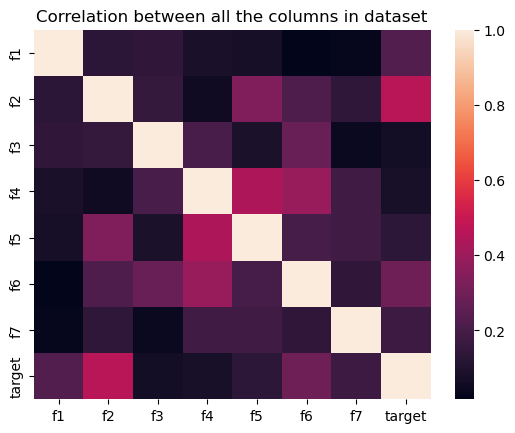

In [13]:
fig = sbs.heatmap(corrMatrix).set(title = 'Correlation between all the columns in dataset')
plt.show()

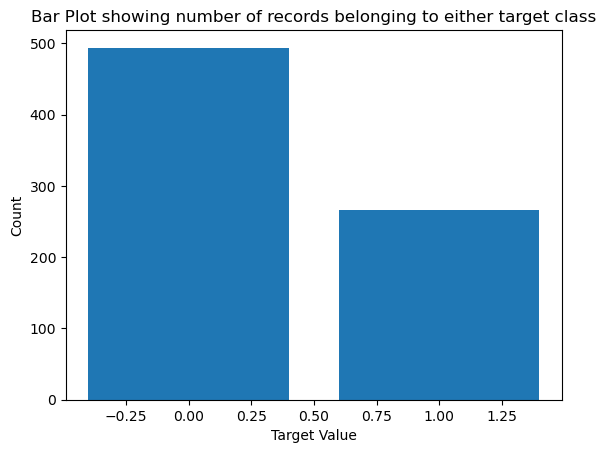

In [14]:
fig = plt.bar(sorted(list(dataset.target.unique())), dataset.groupby(by = ['target'], sort = True).size())
plt.xlabel('Target Value')
plt.ylabel('Count')
plt.title('Bar Plot showing number of records belonging to either target class')
plt.show()

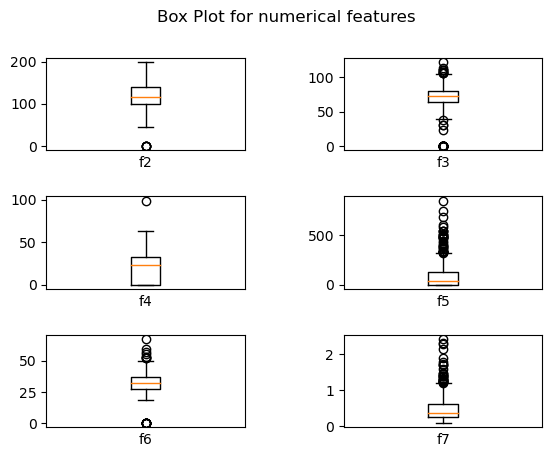

In [15]:
'''
Box Plots for numerical features
'''
fig, axs = plt.subplots(nrows = 3, ncols = 2)

axs[0][0].boxplot(dataset.f2)
axs[0][0].set_xticks([])
axs[0][0].set_xlabel('f2')

axs[0][1].boxplot(dataset.f3)
axs[0][1].set_xticks([])
axs[0][1].set_xlabel('f3')

axs[1][0].boxplot(dataset.f4)
axs[1][0].set_xticks([])
axs[1][0].set_xlabel('f4')

axs[1][1].boxplot(dataset.f5)
axs[1][1].set_xticks([])
axs[1][1].set_xlabel('f5')

axs[2][0].boxplot(dataset.f6)
axs[2][0].set_xticks([])
axs[2][0].set_xlabel('f6')

axs[2][1].boxplot(dataset.f7)
axs[2][1].set_xticks([])
axs[2][1].set_xlabel('f7')

fig.suptitle('Box Plot for numerical features')

plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
plt.show()

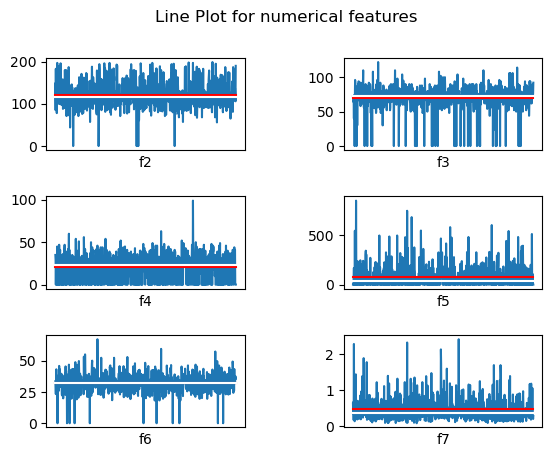

In [16]:
'''
Line Plots for numerical features
'''
fig, axs = plt.subplots(nrows = 3, ncols = 2)
datasetSize = dataset.shape[0]
samples = range(datasetSize)

axs[0][0].plot(samples, dataset.f2)
axs[0][0].plot(samples, [dataset.f2.mean()]*datasetSize, color = 'red')
axs[0][0].plot(samples, [dataset.f2.median()]*datasetSize, color = 'white')
axs[0][0].set_xticks([])
axs[0][0].set_xlabel('f2')

axs[0][1].plot(samples, dataset.f3)
axs[0][1].plot(samples, [dataset.f3.mean()]*datasetSize, color = 'red')
axs[0][1].plot(samples, [dataset.f3.median()]*datasetSize, color = 'white')
axs[0][1].set_xticks([])
axs[0][1].set_xlabel('f3')

axs[1][0].plot(samples, dataset.f4)
axs[1][0].plot(samples, [dataset.f4.mean()]*datasetSize, color = 'red')
axs[1][0].plot(samples, [dataset.f4.median()]*datasetSize, color = 'white')
axs[1][0].set_xticks([])
axs[1][0].set_xlabel('f4')

axs[1][1].plot(samples, dataset.f5)
axs[1][1].plot(samples, [dataset.f5.mean()]*datasetSize, color = 'red')
axs[1][1].plot(samples, [dataset.f5.median()]*datasetSize, color = 'white')
axs[1][1].set_xticks([])
axs[1][1].set_xlabel('f5')

axs[2][0].plot(samples, dataset.f6)
axs[2][0].plot(samples, [dataset.f6.mean()]*datasetSize, color = 'red')
axs[2][0].plot(samples, [dataset.f6.median()]*datasetSize, color = 'white')
axs[2][0].set_xticks([])
axs[2][0].set_xlabel('f6')

axs[2][1].plot(samples, dataset.f7)
axs[2][1].plot(samples, [dataset.f7.mean()]*datasetSize, color = 'red')
axs[2][1].plot(samples, [dataset.f7.median()]*datasetSize, color = 'white')
axs[2][1].set_xticks([])
axs[2][1].set_xlabel('f7')

fig.suptitle('Line Plot for numerical features')

plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
plt.show()

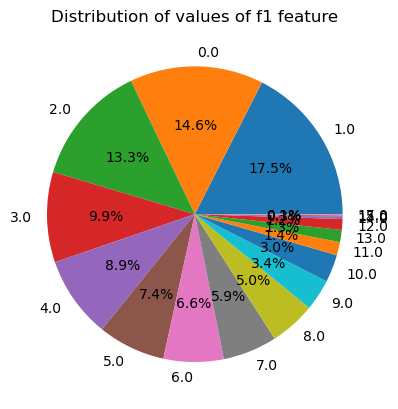

In [17]:
'''
Pie Plot of No. of f1 values in different colors
'''
f1_value_counts = dataset['f1'].value_counts()
plt.pie(f1_value_counts.values,labels=f1_value_counts.index,autopct='%1.1f%%')
plt.title("Distribution of values of f1 feature")
plt.show()

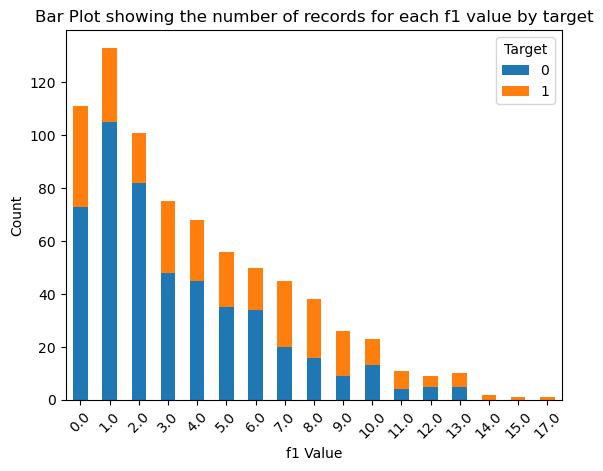

In [18]:
dataset_grouped_by_f1_target = dataset.groupby(['f1', 'target']).size().unstack(fill_value=0)

ax = dataset_grouped_by_f1_target.plot(kind='bar', stacked=True)

plt.xlabel('f1 Value')
plt.ylabel('Count')
plt.title('Bar Plot showing the number of records for each f1 value by target')
plt.xticks(rotation=45) 
plt.legend(title='Target', labels=['0', '1'])

plt.show()

In [19]:
#Outlier Removal
def outlierArray(df, colName, alpha = 1.5):
    Q1 = df[colName].quantile(0.25)
    Q3 = df[colName].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - alpha*IQR
    upper = Q3 + alpha*IQR

    outlierArray = df[(df[colName] < lower) | (df[colName] > upper)]
    
    return outlierArray

In [20]:
outlierIndex = outlierArray(dataset, 'f2', 1.5)
dataset.loc[outlierIndex.index, 'f2'] = dataset['f2'].median()

outlierIndex = outlierArray(dataset, 'f3', 1.5)
dataset.loc[outlierIndex.index, 'f3'] = dataset['f3'].median()

outlierIndex = outlierArray(dataset, 'f4', 1.5)
dataset.loc[outlierIndex.index, 'f4'] = dataset['f4'].median()

outlierIndex = outlierArray(dataset, 'f5', 3)
dataset.loc[outlierIndex.index, 'f5'] = dataset['f5'].mean()

outlierIndex = outlierArray(dataset, 'f6', 1.5)
dataset.loc[outlierIndex.index, 'f6'] = dataset['f6'].median()

outlierIndex = outlierArray(dataset, 'f7', 3)
dataset.loc[outlierIndex.index, 'f7'] = dataset['f7'].mean()

In [21]:
normalizer = StandardScaler() 
columnsList = ['f2','f3','f4','f5','f6','f7']
dataset[columnsList] = normalizer.fit_transform(dataset[columnsList])

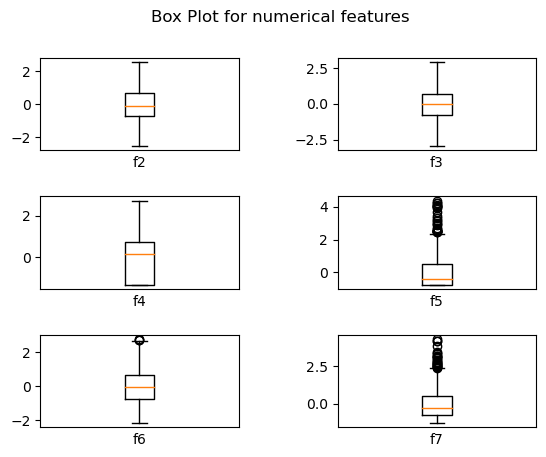

In [22]:
'''
Box Plots for numerical features
'''
fig, axs = plt.subplots(nrows = 3, ncols = 2)

axs[0][0].boxplot(dataset.f2)
axs[0][0].set_xticks([])
axs[0][0].set_xlabel('f2')

axs[0][1].boxplot(dataset.f3)
axs[0][1].set_xticks([])
axs[0][1].set_xlabel('f3')

axs[1][0].boxplot(dataset.f4)
axs[1][0].set_xticks([])
axs[1][0].set_xlabel('f4')

axs[1][1].boxplot(dataset.f5)
axs[1][1].set_xticks([])
axs[1][1].set_xlabel('f5')

axs[2][0].boxplot(dataset.f6)
axs[2][0].set_xticks([])
axs[2][0].set_xlabel('f6')

axs[2][1].boxplot(dataset.f7)
axs[2][1].set_xticks([])
axs[2][1].set_xlabel('f7')

fig.suptitle('Box Plot for numerical features')

plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
plt.show()

In [23]:
dataset = pd.get_dummies(dataset, columns = ['f1'], dtype = float)

In [24]:
dataset.describe()

,f2,f3,f4,f5,f6,f7,target,f1_0.0,f1_1.0,f1_2.0,...,f1_7.0,f1_8.0,f1_9.0,f1_10.0,f1_11.0,f1_12.0,f1_13.0,f1_14.0,f1_15.0,f1_17.0
count,7.600000e+02,7.600000e+02,7.600000e+02,7.600000e+02,7.600000e+02,7.600000e+02,760.000000,760.000000,760.000000,760.000000,...,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000
mean,7.245666e-17,-4.534385e-16,-3.856564e-17,-3.272236e-17,4.651250e-16,1.215402e-16,0.350000,0.146053,0.175000,0.132895,...,0.059211,0.050000,0.034211,0.030263,0.014474,0.011842,0.013158,0.002632,0.001316,0.001316
std,1.000659e+00,1.000659e+00,1.000659e+00,1.000659e+00,1.000659e+00,1.000659e+00,0.477284,0.353392,0.380217,0.339684,...,0.236174,0.218088,0.181889,0.171423,0.119511,0.108246,0.114026,0.051265,0.036274,0.036274
min,-2.552777e+00,-2.951156e+00,-1.300591e+00,-7.456312e-01,-2.185917e+00,-1.290245e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-7.138719e-01,-7.483861e-01,-1.300591e+00,-7.456312e-01,-7.345937e-01,-7.305257e-01,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-1.556329e-01,-1.412961e-02,1.651944e-01,-3.848347e-01,-3.234060e-02,-2.856204e-01,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6.324692e-01,7.201269e-01,7.387626e-01,5.071343e-01,6.387012e-01,5.172351e-01,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2.537049e+00,2.922896e+00,2.714386e+00,4.365652e+00,2.776672e+00,4.291754e+00,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [25]:
dataset.head()

,f2,f3,f4,f5,f6,f7,target,f1_0.0,f1_1.0,f1_2.0,...,f1_7.0,f1_8.0,f1_9.0,f1_10.0,f1_11.0,f1_12.0,f1_13.0,f1_14.0,f1_15.0,f1_17.0
0,0.862332,-0.014130,0.929952,-0.745631,0.217349,0.563667,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.206436,-0.564822,0.547573,-0.745631,-0.875044,-0.368354,0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.011648,-0.748386,-1.300591,-0.745631,-1.390030,0.715627,1,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1.075085,-0.564822,0.165194,0.196448,-0.640960,-0.989702,0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.501119,-2.951156,0.929952,0.938086,1.699884,0.044471,1,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


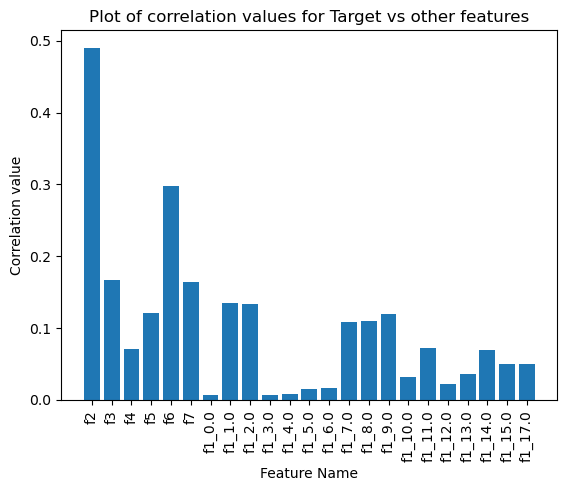

In [26]:
'''
Correlation graph for price feature vs other features
'''
cleanedCorrMatrix = dataset.corr().abs().drop(index = ['target'])
fig = plt.bar(cleanedCorrMatrix['target'].index,cleanedCorrMatrix['target'])
plt.xlabel("Feature Name")
plt.ylabel("Correlation value")
plt.title("Plot of correlation values for Target vs other features")
plt.xticks(rotation=90)
plt.show()

In [27]:
y = dataset.target
X = dataset.drop(columns = ['target'])

In [28]:
test_and_valid_ratio = 0.15

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_and_valid_ratio)

In [30]:
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size = test_and_valid_ratio/(1-test_and_valid_ratio))

In [31]:
print("X_train shape {}, y_train shape {}".format(X_train.shape, y_train.shape))
print("X_validation shape {}, y_validation shape {}".format(X_validation.shape, y_validation.shape))
print("X_test shape {}, y_test shape {}".format(X_test.shape, y_test.shape))

X_train shape (531, 23), y_train shape (531,)
X_validation shape (115, 23), y_validation shape (115,)
X_test shape (114, 23), y_test shape (114,)


In [32]:
lr=0.01
num_epochs = 200
decision_threshold = 0.5
batch_size = 32
in_features_count = X_train.shape[1]

In [33]:
trainDataset = TensorDataset(torch.from_numpy(X_train.to_numpy()).float(), torch.from_numpy(y_train.to_numpy().reshape(-1,1)).float())
trainLoader = DataLoader(trainDataset, batch_size = batch_size, shuffle = True)

In [34]:
validationDataset = TensorDataset(torch.from_numpy(X_validation.to_numpy()).float(), torch.from_numpy(y_validation.to_numpy().reshape(-1,1)).float())
validationLoader = DataLoader(validationDataset, batch_size = batch_size)

In [35]:
testDataset = TensorDataset(torch.from_numpy(X_test.to_numpy()).float(), torch.from_numpy(y_test.to_numpy().reshape(-1,1)).float())
testLoader = DataLoader(testDataset, batch_size = batch_size)

In [36]:
class ModelTrial():
    def __init__(self, model, criterion, optimizer):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.train_metrics = {'accuracy': [], 'loss': []}
        self.validation_metrics = {'accuracy': [], 'loss': []}
        self.test_metrics = {'accuracy': [], 'loss': []}
        self.train_time = None
        self.epochs = []
        self.test_outputs = {}
    def printModel(self):
        print(self.model)
    def printModelSummary(self, batch_size):
        print(torchinfo.summary(self.model, input_size = (batch_size, self.model.in_features_count)))
    def trainingLoop(self, trainLoader, validationLoader, testLoader, num_epochs, decision_threshold, verbose = True):
        self.epochs = range(1, num_epochs+1)
        cumulative_train_time = datetime.timedelta()
        train_dataset_size = len(trainLoader.dataset)
        test_dataset_size = len(testLoader.dataset)
        validation_dataset_size = len(validationLoader.dataset)
    
        for epoch in self.epochs:
            training_loss = 0.0
            training_correct = 0
            t1 = datetime.datetime.now()
            self.model.train()
            for inputs, labels in trainLoader:
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                y_pred = (outputs >= decision_threshold).float()
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                training_loss += loss.item() / (train_dataset_size / trainLoader.batch_size)
                training_correct += (y_pred == labels).sum().item()

            t2 = datetime.datetime.now()
            cumulative_train_time += t2-t1

            training_accuracy = 100 * training_correct / train_dataset_size
            if verbose:
                print(f"Epoch {epoch}, Training Loss: {training_loss:.5f}, Training Accuracy: {training_accuracy:.2f}%")
            self.train_metrics['accuracy'].append(training_accuracy)
            self.train_metrics['loss'].append(training_loss)
            # Validation loop
            validation_loss = 0.0
            validation_correct = 0
            self.model.eval()
            with torch.no_grad():  # Disable gradient computation
                for inputs, labels in validationLoader:
                    outputs = self.model(inputs)
                    y_pred = (outputs >= decision_threshold).float()
                    loss = self.criterion(outputs, labels)
                    validation_loss += loss.item() / (validation_dataset_size / validationLoader.batch_size)

                    validation_correct += (y_pred == labels).sum().item()
                validation_accuracy = 100 * validation_correct / validation_dataset_size
                if verbose:
                    print(f"Epoch {epoch}, Validation Loss: {validation_loss:.5f}, Validation Accuracy: {validation_accuracy:.2f}%")
                self.validation_metrics['accuracy'].append(validation_accuracy)
                self.validation_metrics['loss'].append(validation_loss)
        
        self.model.eval()
        for epoch in self.epochs:
            test_loss = 0.0
            test_correct = 0
            with torch.no_grad():     
                for inputs, labels in testLoader:
                    outputs = self.model(inputs)
                    y_pred = (outputs >= decision_threshold).float()
                    loss = self.criterion(outputs, labels)
                    test_loss += loss.item() / (test_dataset_size / testLoader.batch_size)

                    test_correct += (y_pred == labels).sum().item()

                test_accuracy = 100 * test_correct / test_dataset_size
                self.test_metrics['accuracy'].append(test_accuracy)
                self.test_metrics['loss'].append(test_loss)
        print(f"Epoch {epoch} Training Completed!!")
        print(f"Epoch {epoch}, Testing Loss: {test_loss:.5f}, Testing Accuracy: {test_accuracy:.2f}%")  
        self.train_time = cumulative_train_time
    
    def testDatasetPass(self, X_test, y_test, decision_threshold):
        self.model.eval()
        test_dataset_size = X_test.shape[0]
        inputs = torch.from_numpy(X_test.to_numpy()).float()
        labels = torch.from_numpy(y_test.to_numpy().reshape(-1,1)).float()
        with torch.no_grad():
            outputs = self.model(inputs)
        y_pred = (outputs >= decision_threshold).float()
        self.test_outputs['labels'] = labels
        self.test_outputs['outputs'] = outputs
        self.test_outputs['y_pred'] = y_pred
        
        test_accuracy = 100 * ((y_pred == labels).sum().item()) / test_dataset_size
        self.test_outputs['accuracy'] = test_accuracy
        print("Test Dataset Passed !! Accuracy : {}".format(test_accuracy))
            
    def printTrainTimeStatistics(self):
        print("Time taken to train model (train phase alone considered) is : ")
        days = self.train_time.days
        seconds = self.train_time.seconds
        microseconds = self.train_time.microseconds
        hours, remainder = divmod(seconds, 3600)
        minutes, seconds = divmod(remainder, 60)
        print(f"Days: {days}, Hours: {hours}, Minutes: {minutes}, Seconds: {seconds}, Microseconds: {microseconds}")
        
    def plotLossVsEpochs(self):
        fig = plt.figure()
        plt.xlabel('Epochs')
        plt.ylabel('Loss')

        plt.plot(self.epochs, self.test_metrics['loss'], label = 'Test')
        plt.plot(self.epochs, self.validation_metrics['loss'], label = 'Validation')
        plt.plot(self.epochs, self.train_metrics['loss'], label = 'Train')

        plt.title('Loss vs Epochs graph for Train, Test and Validation Dataset')
        plt.legend()
        plt.show()
    
    def plotAccuracyVsEpochs(self):
        fig = plt.figure()
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')

        plt.plot(self.epochs, self.test_metrics['accuracy'], label = 'Test')
        plt.plot(self.epochs, self.validation_metrics['accuracy'], label = 'Validation')
        plt.plot(self.epochs, self.train_metrics['accuracy'], label = 'Train')

        plt.title('Accuracy vs Epochs graph for Train, Test and Validation Dataset')
        plt.legend()
        plt.show()
    
    def printMetrics(self, outputClasses = [0.0,1.0]):
        precision, recall, fscore, _ = precision_recall_fscore_support(y_true = self.test_outputs['labels'], y_pred = self.test_outputs['y_pred'], average=None,labels=outputClasses)
        print(f"Accuracy for Test Dataset at end of training : {self.test_outputs['accuracy']:.5f}")
        print(f'For Class 0 Precision : {precision[0]:.4f} Recall : {recall[0]:.4f} F1 Score : {fscore[0]:.4f}')
        print(f'For Class 1 Precision : {precision[1]:.4f} Recall : {recall[1]:.4f} F1 Score : {fscore[1]:.4f}')
    
    def plotConfusionMatrix(self, decision_threshold):
        bcm = BinaryConfusionMatrix(threshold = decision_threshold)
        bcm.update(self.test_outputs['outputs'], self.test_outputs['labels'])
        fig,ax = bcm.plot()
        plt.title('Confusion Matrix for Test Dataset')
        plt.plot()
        
    def plotROCgraph(self):
        ROC = BinaryROC()
        ROC.update(self.test_outputs['outputs'], self.test_outputs['labels'].type(torch.int64))
        fig, ax = ROC.plot(score=True)
        plt.title('ROC Curve for Test Dataset')
        plt.show()
    
    def saveModel(self, path):
        torch.save(self.model.state_dict(), path)

In [37]:
class BaseNet(nn.Module):
    def __init__(self, in_features_count):
        super(BaseNet, self).__init__()
        self.fc1 = nn.Linear(in_features_count, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64,16)
        self.fc5 = nn.Linear(16,1)
        self.in_features_count = in_features_count
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.sigmoid(self.fc5(x))
        return x

In [38]:
baseNet = BaseNet(in_features_count = in_features_count)
criterion = nn.BCELoss()  
optimizer = optim.SGD(baseNet.parameters(), lr = lr)

In [39]:
baseModel = ModelTrial(baseNet, criterion, optimizer)

In [40]:
baseModel.printModel()

BaseNet(
  (fc1): Linear(in_features=23, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=16, bias=True)
  (fc5): Linear(in_features=16, out_features=1, bias=True)
)


In [41]:
baseModel.printModelSummary(batch_size = batch_size)

Layer (type:depth-idx)                   Output Shape              Param #
BaseNet                                  [32, 1]                   --
├─Linear: 1-1                            [32, 256]                 6,144
├─Linear: 1-2                            [32, 128]                 32,896
├─Linear: 1-3                            [32, 64]                  8,256
├─Linear: 1-4                            [32, 16]                  1,040
├─Linear: 1-5                            [32, 1]                   17
Total params: 48,353
Trainable params: 48,353
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 1.55
Input size (MB): 0.00
Forward/backward pass size (MB): 0.12
Params size (MB): 0.19
Estimated Total Size (MB): 0.32


In [42]:
baseModel.trainingLoop(trainLoader, validationLoader, testLoader, num_epochs, decision_threshold)

Epoch 1, Training Loss: 0.74682, Training Accuracy: 33.71%
Epoch 1, Validation Loss: 0.79421, Validation Accuracy: 40.00%
Epoch 2, Training Loss: 0.73621, Training Accuracy: 33.71%
Epoch 2, Validation Loss: 0.78712, Validation Accuracy: 40.00%
Epoch 3, Training Loss: 0.72748, Training Accuracy: 33.71%
Epoch 3, Validation Loss: 0.78088, Validation Accuracy: 40.00%
Epoch 4, Training Loss: 0.71910, Training Accuracy: 33.71%
Epoch 4, Validation Loss: 0.77560, Validation Accuracy: 40.00%
Epoch 5, Training Loss: 0.71214, Training Accuracy: 39.92%
Epoch 5, Validation Loss: 0.77105, Validation Accuracy: 61.74%
Epoch 6, Training Loss: 0.70606, Training Accuracy: 67.23%
Epoch 6, Validation Loss: 0.76715, Validation Accuracy: 60.00%
Epoch 7, Training Loss: 0.70020, Training Accuracy: 66.29%
Epoch 7, Validation Loss: 0.76368, Validation Accuracy: 60.00%
Epoch 8, Training Loss: 0.69555, Training Accuracy: 66.29%
Epoch 8, Validation Loss: 0.76081, Validation Accuracy: 60.00%
Epoch 9, Training Loss: 

Epoch 70, Training Loss: 0.61351, Training Accuracy: 66.29%
Epoch 70, Validation Loss: 0.71394, Validation Accuracy: 60.00%
Epoch 71, Training Loss: 0.61166, Training Accuracy: 66.29%
Epoch 71, Validation Loss: 0.71142, Validation Accuracy: 60.00%
Epoch 72, Training Loss: 0.60709, Training Accuracy: 66.29%
Epoch 72, Validation Loss: 0.70907, Validation Accuracy: 60.00%
Epoch 73, Training Loss: 0.60675, Training Accuracy: 66.29%
Epoch 73, Validation Loss: 0.70640, Validation Accuracy: 60.00%
Epoch 74, Training Loss: 0.60291, Training Accuracy: 66.29%
Epoch 74, Validation Loss: 0.70373, Validation Accuracy: 60.00%
Epoch 75, Training Loss: 0.60054, Training Accuracy: 66.29%
Epoch 75, Validation Loss: 0.70084, Validation Accuracy: 60.00%
Epoch 76, Training Loss: 0.59427, Training Accuracy: 66.29%
Epoch 76, Validation Loss: 0.69807, Validation Accuracy: 60.00%
Epoch 77, Training Loss: 0.59634, Training Accuracy: 66.29%
Epoch 77, Validation Loss: 0.69502, Validation Accuracy: 60.00%
Epoch 78

Epoch 138, Training Loss: 0.46172, Training Accuracy: 79.10%
Epoch 138, Validation Loss: 0.61470, Validation Accuracy: 72.17%
Epoch 139, Training Loss: 0.45980, Training Accuracy: 78.72%
Epoch 139, Validation Loss: 0.61536, Validation Accuracy: 72.17%
Epoch 140, Training Loss: 0.45693, Training Accuracy: 78.72%
Epoch 140, Validation Loss: 0.61899, Validation Accuracy: 72.17%
Epoch 141, Training Loss: 0.45293, Training Accuracy: 78.53%
Epoch 141, Validation Loss: 0.62014, Validation Accuracy: 72.17%
Epoch 142, Training Loss: 0.46261, Training Accuracy: 78.91%
Epoch 142, Validation Loss: 0.61935, Validation Accuracy: 72.17%
Epoch 143, Training Loss: 0.45107, Training Accuracy: 78.91%
Epoch 143, Validation Loss: 0.62463, Validation Accuracy: 72.17%
Epoch 144, Training Loss: 0.45488, Training Accuracy: 78.91%
Epoch 144, Validation Loss: 0.62153, Validation Accuracy: 72.17%
Epoch 145, Training Loss: 0.45107, Training Accuracy: 78.91%
Epoch 145, Validation Loss: 0.62074, Validation Accuracy:

In [43]:
baseModel.printTrainTimeStatistics()

Time taken to train model (train phase alone considered) is : 
Days: 0, Hours: 0, Minutes: 0, Seconds: 6, Microseconds: 557415


In [44]:
baseModel.testDatasetPass(X_test, y_test, decision_threshold)

Test Dataset Passed !! Accuracy : 77.19298245614036


In [45]:
baseModel.printMetrics()

Accuracy for Test Dataset at end of training : 77.19298
For Class 0 Precision : 0.7901 Recall : 0.8767 F1 Score : 0.8312
For Class 1 Precision : 0.7273 Recall : 0.5854 F1 Score : 0.6486


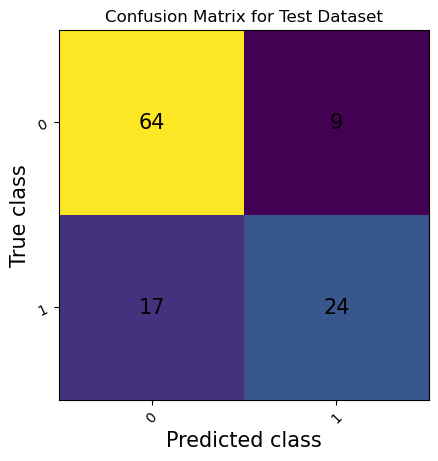

In [46]:
baseModel.plotConfusionMatrix(decision_threshold)

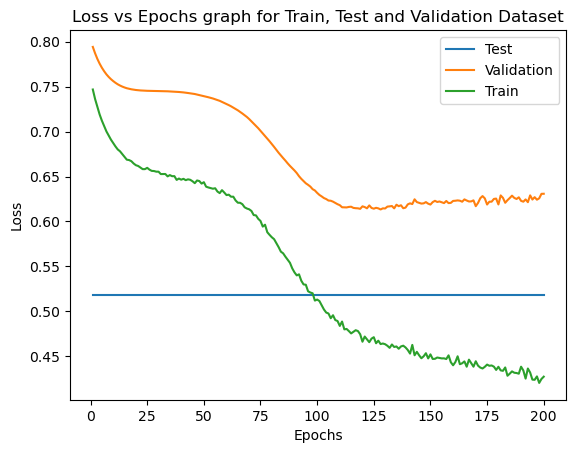

In [47]:
baseModel.plotLossVsEpochs()

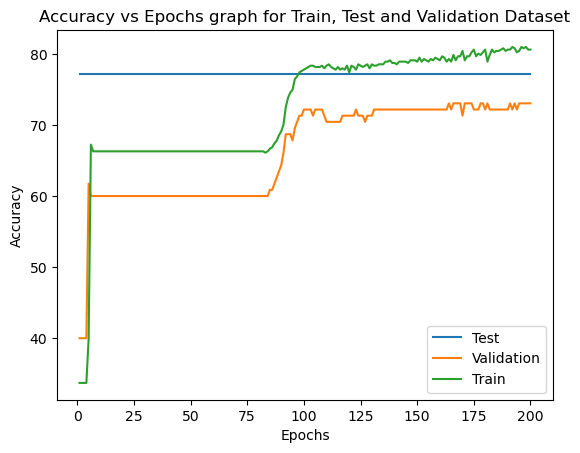

In [48]:
baseModel.plotAccuracyVsEpochs()

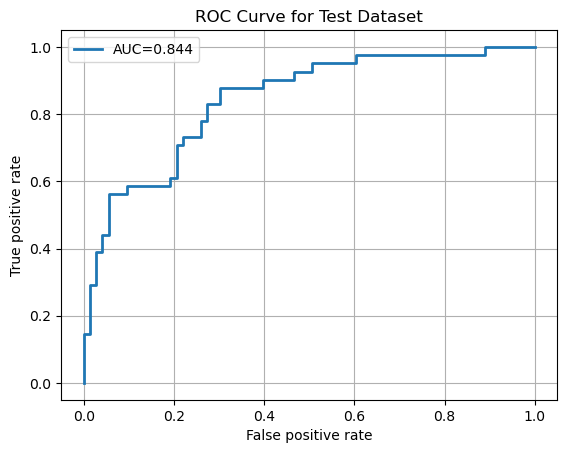

In [49]:
baseModel.plotROCgraph()

In [50]:
baseModel.saveModel(path = 'sainath_assignment2_part1.pth')

## Hyperparameter 1 - Optimizer
We will test the following three optimizer methods:
1) Adam
2) RMSprop
3) Adagrad

### Adam Optimizer

In [51]:
optNet1 = BaseNet(in_features_count = in_features_count)
criterion = nn.BCELoss()  
optimizer1 = optim.Adam(optNet1.parameters(), lr=lr, betas=(0.9, 0.999))

In [52]:
optOneModel = ModelTrial(optNet1, criterion, optimizer1)

In [53]:
optOneModel.printModel()

BaseNet(
  (fc1): Linear(in_features=23, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=16, bias=True)
  (fc5): Linear(in_features=16, out_features=1, bias=True)
)


In [54]:
optOneModel.printModelSummary(batch_size = batch_size)

Layer (type:depth-idx)                   Output Shape              Param #
BaseNet                                  [32, 1]                   --
├─Linear: 1-1                            [32, 256]                 6,144
├─Linear: 1-2                            [32, 128]                 32,896
├─Linear: 1-3                            [32, 64]                  8,256
├─Linear: 1-4                            [32, 16]                  1,040
├─Linear: 1-5                            [32, 1]                   17
Total params: 48,353
Trainable params: 48,353
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 1.55
Input size (MB): 0.00
Forward/backward pass size (MB): 0.12
Params size (MB): 0.19
Estimated Total Size (MB): 0.32


In [55]:
optOneModel.trainingLoop(trainLoader, validationLoader, testLoader, num_epochs, decision_threshold)

Epoch 1, Training Loss: 0.56407, Training Accuracy: 71.19%
Epoch 1, Validation Loss: 0.60699, Validation Accuracy: 72.17%
Epoch 2, Training Loss: 0.48464, Training Accuracy: 78.53%
Epoch 2, Validation Loss: 0.59521, Validation Accuracy: 74.78%
Epoch 3, Training Loss: 0.44260, Training Accuracy: 79.10%
Epoch 3, Validation Loss: 0.64036, Validation Accuracy: 71.30%
Epoch 4, Training Loss: 0.42301, Training Accuracy: 80.04%
Epoch 4, Validation Loss: 0.62054, Validation Accuracy: 69.57%
Epoch 5, Training Loss: 0.40411, Training Accuracy: 82.11%
Epoch 5, Validation Loss: 0.63331, Validation Accuracy: 68.70%
Epoch 6, Training Loss: 0.38435, Training Accuracy: 82.11%
Epoch 6, Validation Loss: 0.68256, Validation Accuracy: 66.96%
Epoch 7, Training Loss: 0.35833, Training Accuracy: 83.24%
Epoch 7, Validation Loss: 0.72289, Validation Accuracy: 68.70%
Epoch 8, Training Loss: 0.34278, Training Accuracy: 84.18%
Epoch 8, Validation Loss: 0.78617, Validation Accuracy: 66.09%
Epoch 9, Training Loss: 

Epoch 69, Training Loss: 0.03482, Training Accuracy: 98.31%
Epoch 69, Validation Loss: 12.83461, Validation Accuracy: 70.43%
Epoch 70, Training Loss: 0.02036, Training Accuracy: 99.06%
Epoch 70, Validation Loss: 12.40014, Validation Accuracy: 73.04%
Epoch 71, Training Loss: 0.02699, Training Accuracy: 98.49%
Epoch 71, Validation Loss: 15.08773, Validation Accuracy: 70.43%
Epoch 72, Training Loss: 0.26831, Training Accuracy: 98.12%
Epoch 72, Validation Loss: 4.63550, Validation Accuracy: 70.43%
Epoch 73, Training Loss: 0.10388, Training Accuracy: 96.05%
Epoch 73, Validation Loss: 3.81072, Validation Accuracy: 70.43%
Epoch 74, Training Loss: 0.08421, Training Accuracy: 97.36%
Epoch 74, Validation Loss: 2.95556, Validation Accuracy: 66.96%
Epoch 75, Training Loss: 0.06257, Training Accuracy: 97.93%
Epoch 75, Validation Loss: 6.27850, Validation Accuracy: 68.70%
Epoch 76, Training Loss: 0.04985, Training Accuracy: 97.55%
Epoch 76, Validation Loss: 9.00152, Validation Accuracy: 66.96%
Epoch

Epoch 136, Training Loss: 0.00743, Training Accuracy: 99.62%
Epoch 136, Validation Loss: 14.49737, Validation Accuracy: 69.57%
Epoch 137, Training Loss: 0.00876, Training Accuracy: 99.62%
Epoch 137, Validation Loss: 14.53704, Validation Accuracy: 69.57%
Epoch 138, Training Loss: 0.00739, Training Accuracy: 99.62%
Epoch 138, Validation Loss: 14.56724, Validation Accuracy: 69.57%
Epoch 139, Training Loss: 0.00749, Training Accuracy: 99.62%
Epoch 139, Validation Loss: 14.58489, Validation Accuracy: 69.57%
Epoch 140, Training Loss: 0.00738, Training Accuracy: 99.62%
Epoch 140, Validation Loss: 14.61566, Validation Accuracy: 69.57%
Epoch 141, Training Loss: 0.00737, Training Accuracy: 99.62%
Epoch 141, Validation Loss: 14.63621, Validation Accuracy: 69.57%
Epoch 142, Training Loss: 0.00747, Training Accuracy: 99.62%
Epoch 142, Validation Loss: 14.66300, Validation Accuracy: 69.57%
Epoch 143, Training Loss: 0.00738, Training Accuracy: 99.62%
Epoch 143, Validation Loss: 14.67573, Validation A

Epoch 200 Training Completed!!
Epoch 200, Testing Loss: 4.00420, Testing Accuracy: 74.56%


In [56]:
optOneModel.printTrainTimeStatistics()

Time taken to train model (train phase alone considered) is : 
Days: 0, Hours: 0, Minutes: 0, Seconds: 13, Microseconds: 823078


In [57]:
optOneModel.testDatasetPass(X_test, y_test, decision_threshold)

Test Dataset Passed !! Accuracy : 74.56140350877193


In [58]:
optOneModel.printMetrics()

Accuracy for Test Dataset at end of training : 74.56140
For Class 0 Precision : 0.8056 Recall : 0.7945 F1 Score : 0.8000
For Class 1 Precision : 0.6429 Recall : 0.6585 F1 Score : 0.6506


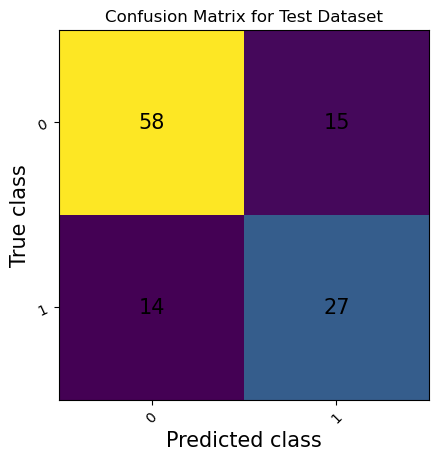

In [59]:
optOneModel.plotConfusionMatrix(decision_threshold)

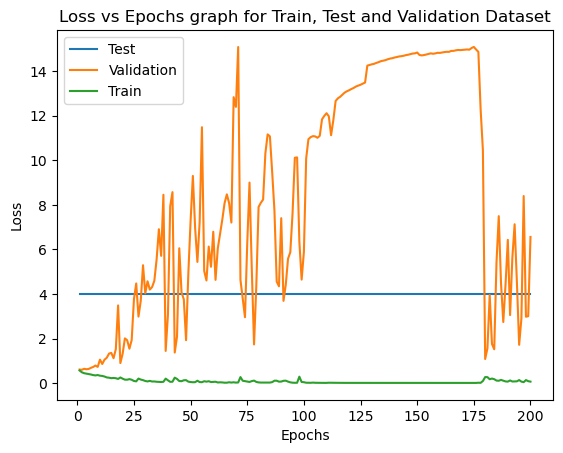

In [60]:
optOneModel.plotLossVsEpochs()

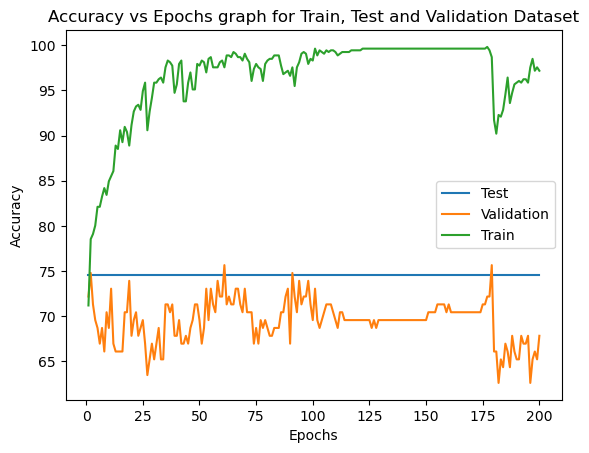

In [61]:
optOneModel.plotAccuracyVsEpochs()

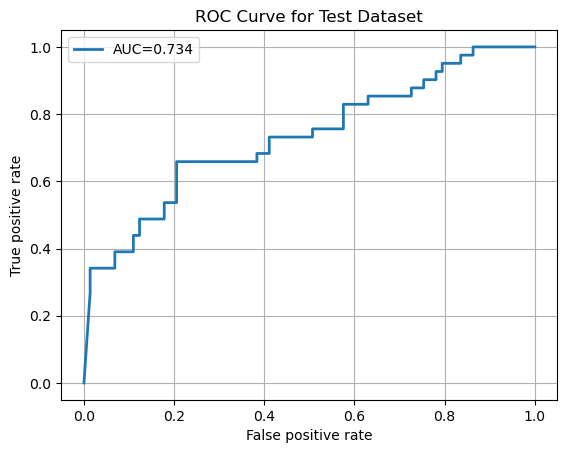

In [62]:
optOneModel.plotROCgraph()

### RMSprop optimizer

In [63]:
optNet2 = BaseNet(in_features_count = in_features_count)
criterion = nn.BCELoss()  
optimizer2 = optim.RMSprop(optNet2.parameters(), lr=lr, alpha = 0.99)

In [64]:
optTwoModel = ModelTrial(optNet2, criterion, optimizer2)

In [65]:
optTwoModel.printModel()

BaseNet(
  (fc1): Linear(in_features=23, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=16, bias=True)
  (fc5): Linear(in_features=16, out_features=1, bias=True)
)


In [66]:
optTwoModel.printModelSummary(batch_size = batch_size)

Layer (type:depth-idx)                   Output Shape              Param #
BaseNet                                  [32, 1]                   --
├─Linear: 1-1                            [32, 256]                 6,144
├─Linear: 1-2                            [32, 128]                 32,896
├─Linear: 1-3                            [32, 64]                  8,256
├─Linear: 1-4                            [32, 16]                  1,040
├─Linear: 1-5                            [32, 1]                   17
Total params: 48,353
Trainable params: 48,353
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 1.55
Input size (MB): 0.00
Forward/backward pass size (MB): 0.12
Params size (MB): 0.19
Estimated Total Size (MB): 0.32


In [67]:
optTwoModel.trainingLoop(trainLoader, validationLoader, testLoader, num_epochs, decision_threshold)

Epoch 1, Training Loss: 12.19317, Training Accuracy: 58.19%
Epoch 1, Validation Loss: 0.65279, Validation Accuracy: 60.00%
Epoch 2, Training Loss: 0.51343, Training Accuracy: 72.32%
Epoch 2, Validation Loss: 0.62642, Validation Accuracy: 65.22%
Epoch 3, Training Loss: 0.44687, Training Accuracy: 77.21%
Epoch 3, Validation Loss: 0.67299, Validation Accuracy: 67.83%
Epoch 4, Training Loss: 0.42948, Training Accuracy: 79.28%
Epoch 4, Validation Loss: 0.66193, Validation Accuracy: 66.09%
Epoch 5, Training Loss: 0.41308, Training Accuracy: 80.60%
Epoch 5, Validation Loss: 0.65100, Validation Accuracy: 70.43%
Epoch 6, Training Loss: 0.40238, Training Accuracy: 81.92%
Epoch 6, Validation Loss: 0.76582, Validation Accuracy: 66.09%
Epoch 7, Training Loss: 0.38545, Training Accuracy: 82.49%
Epoch 7, Validation Loss: 0.80459, Validation Accuracy: 67.83%
Epoch 8, Training Loss: 0.37958, Training Accuracy: 83.05%
Epoch 8, Validation Loss: 0.72386, Validation Accuracy: 67.83%
Epoch 9, Training Loss:

Epoch 68, Training Loss: 0.02609, Training Accuracy: 98.31%
Epoch 68, Validation Loss: 11.37748, Validation Accuracy: 65.22%
Epoch 69, Training Loss: 0.02614, Training Accuracy: 98.31%
Epoch 69, Validation Loss: 12.17712, Validation Accuracy: 65.22%
Epoch 70, Training Loss: 0.02721, Training Accuracy: 98.31%
Epoch 70, Validation Loss: 13.01500, Validation Accuracy: 65.22%
Epoch 71, Training Loss: 0.02607, Training Accuracy: 98.31%
Epoch 71, Validation Loss: 13.06064, Validation Accuracy: 65.22%
Epoch 72, Training Loss: 0.02607, Training Accuracy: 98.31%
Epoch 72, Validation Loss: 13.10424, Validation Accuracy: 65.22%
Epoch 73, Training Loss: 0.02774, Training Accuracy: 98.31%
Epoch 73, Validation Loss: 14.72890, Validation Accuracy: 63.48%
Epoch 74, Training Loss: 0.88271, Training Accuracy: 92.84%
Epoch 74, Validation Loss: 1.94656, Validation Accuracy: 68.70%
Epoch 75, Training Loss: 0.22289, Training Accuracy: 90.96%
Epoch 75, Validation Loss: 5.94062, Validation Accuracy: 64.35%
Ep

Epoch 138, Training Loss: 0.00939, Training Accuracy: 99.62%
Epoch 138, Validation Loss: 11.83724, Validation Accuracy: 66.09%
Epoch 139, Training Loss: 0.00878, Training Accuracy: 99.44%
Epoch 139, Validation Loss: 11.84058, Validation Accuracy: 65.22%
Epoch 140, Training Loss: 0.00687, Training Accuracy: 99.62%
Epoch 140, Validation Loss: 11.90163, Validation Accuracy: 65.22%
Epoch 141, Training Loss: 0.00628, Training Accuracy: 99.62%
Epoch 141, Validation Loss: 11.99470, Validation Accuracy: 65.22%
Epoch 142, Training Loss: 0.00606, Training Accuracy: 99.81%
Epoch 142, Validation Loss: 12.13083, Validation Accuracy: 66.09%
Epoch 143, Training Loss: 0.00645, Training Accuracy: 99.62%
Epoch 143, Validation Loss: 12.21524, Validation Accuracy: 66.09%
Epoch 144, Training Loss: 0.01023, Training Accuracy: 99.62%
Epoch 144, Validation Loss: 14.38414, Validation Accuracy: 65.22%
Epoch 145, Training Loss: 0.02080, Training Accuracy: 99.25%
Epoch 145, Validation Loss: 6.31901, Validation Ac

In [68]:
optTwoModel.printTrainTimeStatistics()

Time taken to train model (train phase alone considered) is : 
Days: 0, Hours: 0, Minutes: 0, Seconds: 8, Microseconds: 764178


In [69]:
optTwoModel.testDatasetPass(X_test, y_test, decision_threshold)

Test Dataset Passed !! Accuracy : 71.05263157894737


In [70]:
optTwoModel.printMetrics()

Accuracy for Test Dataset at end of training : 71.05263
For Class 0 Precision : 0.7778 Recall : 0.7671 F1 Score : 0.7724
For Class 1 Precision : 0.5952 Recall : 0.6098 F1 Score : 0.6024


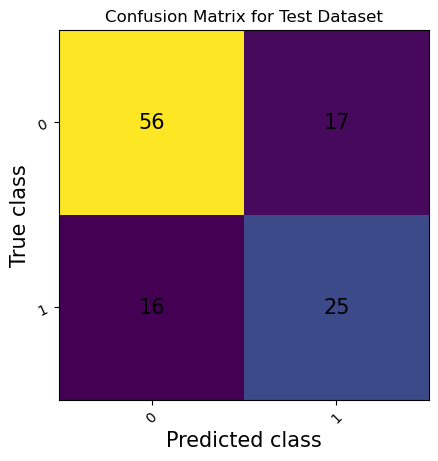

In [71]:
optTwoModel.plotConfusionMatrix(decision_threshold)

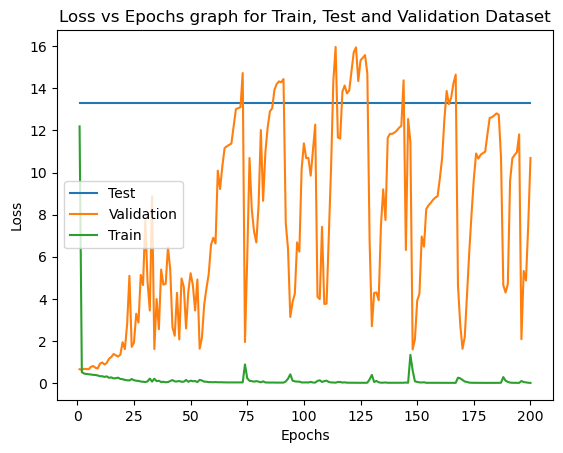

In [72]:
optTwoModel.plotLossVsEpochs()

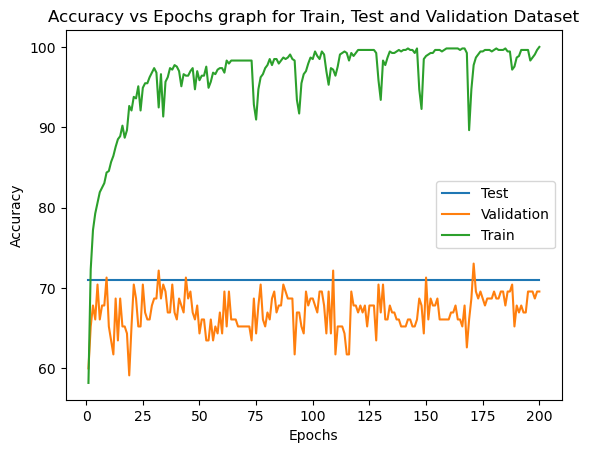

In [73]:
optTwoModel.plotAccuracyVsEpochs()

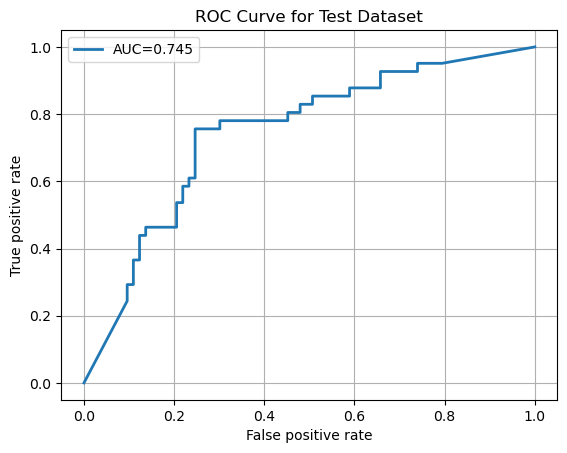

In [74]:
optTwoModel.plotROCgraph()

### Adagrad optimizer

In [75]:
optNet3 = BaseNet(in_features_count = in_features_count)
criterion = nn.BCELoss()  
optimizer3 = optim.Adagrad(optNet3.parameters(), lr=lr)

In [76]:
optThreeModel = ModelTrial(optNet3, criterion, optimizer3)

In [77]:
optThreeModel.printModel()

BaseNet(
  (fc1): Linear(in_features=23, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=16, bias=True)
  (fc5): Linear(in_features=16, out_features=1, bias=True)
)


In [78]:
optThreeModel.printModelSummary(batch_size = batch_size)

Layer (type:depth-idx)                   Output Shape              Param #
BaseNet                                  [32, 1]                   --
├─Linear: 1-1                            [32, 256]                 6,144
├─Linear: 1-2                            [32, 128]                 32,896
├─Linear: 1-3                            [32, 64]                  8,256
├─Linear: 1-4                            [32, 16]                  1,040
├─Linear: 1-5                            [32, 1]                   17
Total params: 48,353
Trainable params: 48,353
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 1.55
Input size (MB): 0.00
Forward/backward pass size (MB): 0.12
Params size (MB): 0.19
Estimated Total Size (MB): 0.32


In [79]:
optThreeModel.trainingLoop(trainLoader, validationLoader, testLoader, num_epochs, decision_threshold)

Epoch 1, Training Loss: 0.60087, Training Accuracy: 67.98%
Epoch 1, Validation Loss: 0.61240, Validation Accuracy: 71.30%
Epoch 2, Training Loss: 0.48136, Training Accuracy: 78.53%
Epoch 2, Validation Loss: 0.65088, Validation Accuracy: 70.43%
Epoch 3, Training Loss: 0.46618, Training Accuracy: 79.66%
Epoch 3, Validation Loss: 0.61284, Validation Accuracy: 71.30%
Epoch 4, Training Loss: 0.46059, Training Accuracy: 78.72%
Epoch 4, Validation Loss: 0.62549, Validation Accuracy: 72.17%
Epoch 5, Training Loss: 0.43631, Training Accuracy: 80.04%
Epoch 5, Validation Loss: 0.63074, Validation Accuracy: 72.17%
Epoch 6, Training Loss: 0.43725, Training Accuracy: 79.85%
Epoch 6, Validation Loss: 0.64293, Validation Accuracy: 71.30%
Epoch 7, Training Loss: 0.43400, Training Accuracy: 79.85%
Epoch 7, Validation Loss: 0.64090, Validation Accuracy: 73.04%
Epoch 8, Training Loss: 0.42508, Training Accuracy: 81.17%
Epoch 8, Validation Loss: 0.65391, Validation Accuracy: 71.30%
Epoch 9, Training Loss: 

Epoch 72, Training Loss: 0.03811, Training Accuracy: 99.44%
Epoch 72, Validation Loss: 1.97379, Validation Accuracy: 67.83%
Epoch 73, Training Loss: 0.03145, Training Accuracy: 99.62%
Epoch 73, Validation Loss: 2.01363, Validation Accuracy: 64.35%
Epoch 74, Training Loss: 0.03033, Training Accuracy: 99.44%
Epoch 74, Validation Loss: 2.01093, Validation Accuracy: 66.09%
Epoch 75, Training Loss: 0.02902, Training Accuracy: 99.06%
Epoch 75, Validation Loss: 2.76177, Validation Accuracy: 66.09%
Epoch 76, Training Loss: 0.02679, Training Accuracy: 99.81%
Epoch 76, Validation Loss: 2.88638, Validation Accuracy: 65.22%
Epoch 77, Training Loss: 0.03301, Training Accuracy: 99.06%
Epoch 77, Validation Loss: 2.81759, Validation Accuracy: 65.22%
Epoch 78, Training Loss: 0.02661, Training Accuracy: 99.25%
Epoch 78, Validation Loss: 3.64583, Validation Accuracy: 65.22%
Epoch 79, Training Loss: 0.02357, Training Accuracy: 99.62%
Epoch 79, Validation Loss: 3.68027, Validation Accuracy: 65.22%
Epoch 80

Epoch 141, Training Loss: 0.00499, Training Accuracy: 100.00%
Epoch 141, Validation Loss: 5.16995, Validation Accuracy: 65.22%
Epoch 142, Training Loss: 0.00411, Training Accuracy: 100.00%
Epoch 142, Validation Loss: 5.92843, Validation Accuracy: 65.22%
Epoch 143, Training Loss: 0.00484, Training Accuracy: 100.00%
Epoch 143, Validation Loss: 5.92279, Validation Accuracy: 65.22%
Epoch 144, Training Loss: 0.00504, Training Accuracy: 100.00%
Epoch 144, Validation Loss: 5.93591, Validation Accuracy: 65.22%
Epoch 145, Training Loss: 0.00464, Training Accuracy: 100.00%
Epoch 145, Validation Loss: 6.00483, Validation Accuracy: 65.22%
Epoch 146, Training Loss: 0.00444, Training Accuracy: 100.00%
Epoch 146, Validation Loss: 5.94121, Validation Accuracy: 65.22%
Epoch 147, Training Loss: 0.00397, Training Accuracy: 100.00%
Epoch 147, Validation Loss: 5.99376, Validation Accuracy: 65.22%
Epoch 148, Training Loss: 0.00455, Training Accuracy: 100.00%
Epoch 148, Validation Loss: 5.97595, Validation A

In [80]:
optThreeModel.printTrainTimeStatistics()

Time taken to train model (train phase alone considered) is : 
Days: 0, Hours: 0, Minutes: 0, Seconds: 8, Microseconds: 859619


In [81]:
optThreeModel.testDatasetPass(X_test, y_test, decision_threshold)

Test Dataset Passed !! Accuracy : 75.43859649122807


In [82]:
optThreeModel.printMetrics()

Accuracy for Test Dataset at end of training : 75.43860
For Class 0 Precision : 0.7922 Recall : 0.8356 F1 Score : 0.8133
For Class 1 Precision : 0.6757 Recall : 0.6098 F1 Score : 0.6410


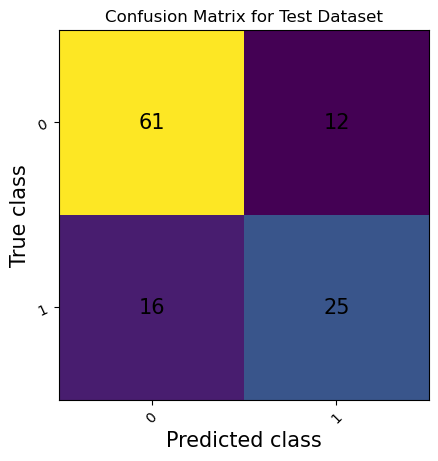

In [83]:
optThreeModel.plotConfusionMatrix(decision_threshold)

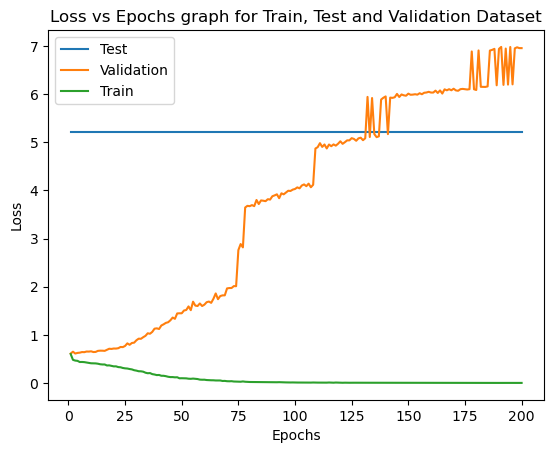

In [84]:
optThreeModel.plotLossVsEpochs()

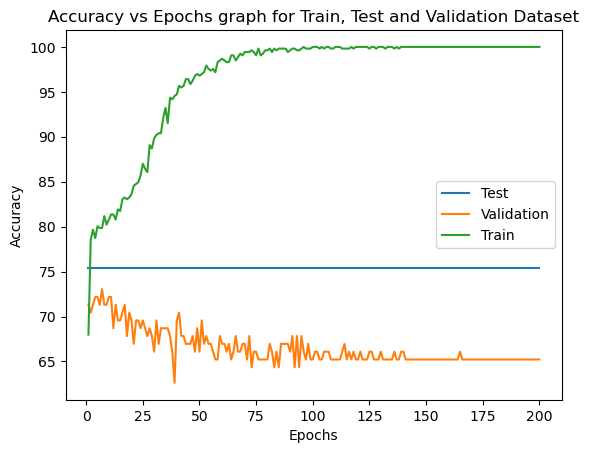

In [85]:
optThreeModel.plotAccuracyVsEpochs()

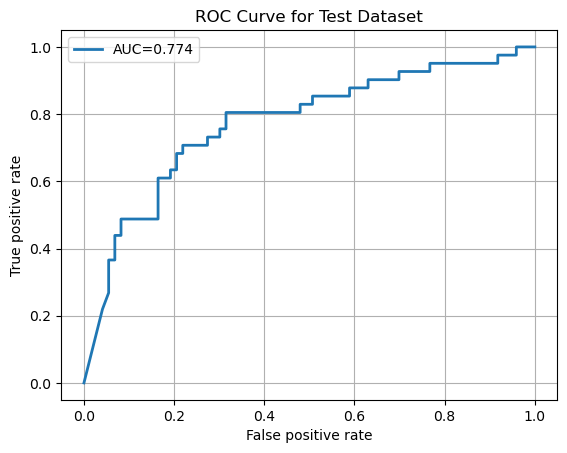

In [86]:
optThreeModel.plotROCgraph()

## Hyperparameter 2 - Dropout Regularization

In this hyperparameter search we will add dropout regularization to output of fc2 fully connected layer and try three different dropout probabilities.
We will test the following three dropout probabilities:
1) 0.25
2) 0.5
3) 0.75

In [87]:
class DropoutNet(nn.Module):
    def __init__(self, in_features_count, dropout_prob):
        super(DropoutNet, self).__init__()
        self.fc1 = nn.Linear(in_features_count, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64,16)
        self.fc5 = nn.Linear(16,1)
        self.dropout = nn.Dropout(p = dropout_prob)
        self.in_features_count = in_features_count
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.sigmoid(self.fc5(x))
        return x

### Dropout Probability 0.25

In [88]:
dropoutNet1 = DropoutNet(in_features_count = in_features_count, dropout_prob = 0.25)
criterion = nn.BCELoss()  
optimizer = optim.SGD(dropoutNet1.parameters(), lr=lr)

In [89]:
dropoutOneModel = ModelTrial(dropoutNet1, criterion, optimizer)

In [90]:
dropoutOneModel.printModel()

DropoutNet(
  (fc1): Linear(in_features=23, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=16, bias=True)
  (fc5): Linear(in_features=16, out_features=1, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [91]:
dropoutOneModel.printModelSummary(batch_size = batch_size)

Layer (type:depth-idx)                   Output Shape              Param #
DropoutNet                               [32, 1]                   --
├─Linear: 1-1                            [32, 256]                 6,144
├─Linear: 1-2                            [32, 128]                 32,896
├─Dropout: 1-3                           [32, 128]                 --
├─Linear: 1-4                            [32, 64]                  8,256
├─Linear: 1-5                            [32, 16]                  1,040
├─Linear: 1-6                            [32, 1]                   17
Total params: 48,353
Trainable params: 48,353
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 1.55
Input size (MB): 0.00
Forward/backward pass size (MB): 0.12
Params size (MB): 0.19
Estimated Total Size (MB): 0.32


In [92]:
dropoutOneModel.trainingLoop(trainLoader, validationLoader, testLoader, num_epochs, decision_threshold)

Epoch 1, Training Loss: 0.74699, Training Accuracy: 33.71%
Epoch 1, Validation Loss: 0.79390, Validation Accuracy: 40.00%
Epoch 2, Training Loss: 0.73714, Training Accuracy: 33.71%
Epoch 2, Validation Loss: 0.78779, Validation Accuracy: 40.00%
Epoch 3, Training Loss: 0.72949, Training Accuracy: 33.71%
Epoch 3, Validation Loss: 0.78225, Validation Accuracy: 40.00%
Epoch 4, Training Loss: 0.72257, Training Accuracy: 33.71%
Epoch 4, Validation Loss: 0.77720, Validation Accuracy: 40.00%
Epoch 5, Training Loss: 0.71624, Training Accuracy: 33.71%
Epoch 5, Validation Loss: 0.77267, Validation Accuracy: 40.00%
Epoch 6, Training Loss: 0.70991, Training Accuracy: 51.04%
Epoch 6, Validation Loss: 0.76857, Validation Accuracy: 60.87%
Epoch 7, Training Loss: 0.70410, Training Accuracy: 67.42%
Epoch 7, Validation Loss: 0.76487, Validation Accuracy: 60.00%
Epoch 8, Training Loss: 0.69919, Training Accuracy: 66.29%
Epoch 8, Validation Loss: 0.76175, Validation Accuracy: 60.00%
Epoch 9, Training Loss: 

Epoch 73, Training Loss: 0.58693, Training Accuracy: 66.29%
Epoch 73, Validation Loss: 0.68877, Validation Accuracy: 60.00%
Epoch 74, Training Loss: 0.58517, Training Accuracy: 66.29%
Epoch 74, Validation Loss: 0.68663, Validation Accuracy: 60.00%
Epoch 75, Training Loss: 0.57690, Training Accuracy: 66.29%
Epoch 75, Validation Loss: 0.68448, Validation Accuracy: 60.00%
Epoch 76, Training Loss: 0.58096, Training Accuracy: 66.29%
Epoch 76, Validation Loss: 0.68214, Validation Accuracy: 60.00%
Epoch 77, Training Loss: 0.57534, Training Accuracy: 66.29%
Epoch 77, Validation Loss: 0.68006, Validation Accuracy: 60.00%
Epoch 78, Training Loss: 0.57295, Training Accuracy: 66.29%
Epoch 78, Validation Loss: 0.67819, Validation Accuracy: 60.00%
Epoch 79, Training Loss: 0.56858, Training Accuracy: 66.29%
Epoch 79, Validation Loss: 0.67601, Validation Accuracy: 60.00%
Epoch 80, Training Loss: 0.56358, Training Accuracy: 66.29%
Epoch 80, Validation Loss: 0.67421, Validation Accuracy: 60.00%
Epoch 81

Epoch 144, Training Loss: 0.46536, Training Accuracy: 79.28%
Epoch 144, Validation Loss: 0.63127, Validation Accuracy: 73.04%
Epoch 145, Training Loss: 0.47257, Training Accuracy: 78.15%
Epoch 145, Validation Loss: 0.62856, Validation Accuracy: 73.04%
Epoch 146, Training Loss: 0.46964, Training Accuracy: 79.28%
Epoch 146, Validation Loss: 0.62937, Validation Accuracy: 73.04%
Epoch 147, Training Loss: 0.46798, Training Accuracy: 78.34%
Epoch 147, Validation Loss: 0.62910, Validation Accuracy: 73.91%
Epoch 148, Training Loss: 0.46032, Training Accuracy: 78.91%
Epoch 148, Validation Loss: 0.62941, Validation Accuracy: 73.04%
Epoch 149, Training Loss: 0.46836, Training Accuracy: 78.91%
Epoch 149, Validation Loss: 0.62875, Validation Accuracy: 73.04%
Epoch 150, Training Loss: 0.46546, Training Accuracy: 79.10%
Epoch 150, Validation Loss: 0.63027, Validation Accuracy: 73.04%
Epoch 151, Training Loss: 0.46616, Training Accuracy: 78.91%
Epoch 151, Validation Loss: 0.62886, Validation Accuracy:

In [93]:
dropoutOneModel.printTrainTimeStatistics()

Time taken to train model (train phase alone considered) is : 
Days: 0, Hours: 0, Minutes: 0, Seconds: 6, Microseconds: 842680


In [94]:
dropoutOneModel.testDatasetPass(X_test, y_test, decision_threshold)

Test Dataset Passed !! Accuracy : 78.0701754385965


In [95]:
dropoutOneModel.printMetrics()

Accuracy for Test Dataset at end of training : 78.07018
For Class 0 Precision : 0.8077 Recall : 0.8630 F1 Score : 0.8344
For Class 1 Precision : 0.7222 Recall : 0.6341 F1 Score : 0.6753


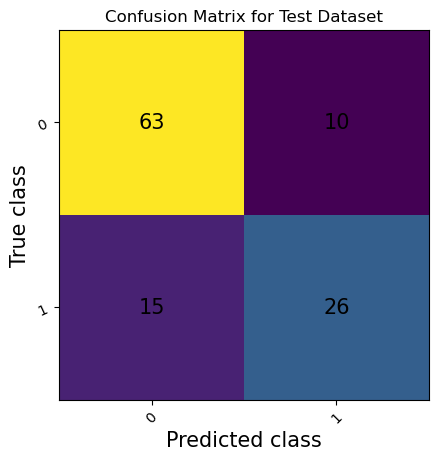

In [96]:
dropoutOneModel.plotConfusionMatrix(decision_threshold)

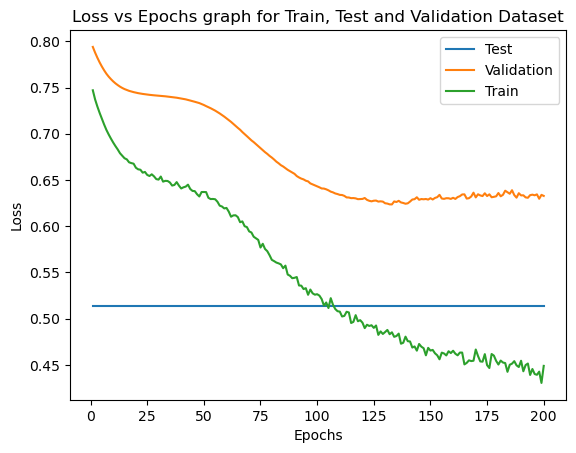

In [97]:
dropoutOneModel.plotLossVsEpochs()

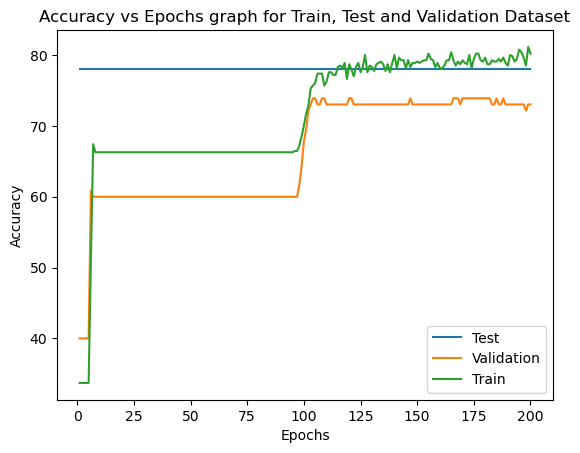

In [98]:
dropoutOneModel.plotAccuracyVsEpochs()

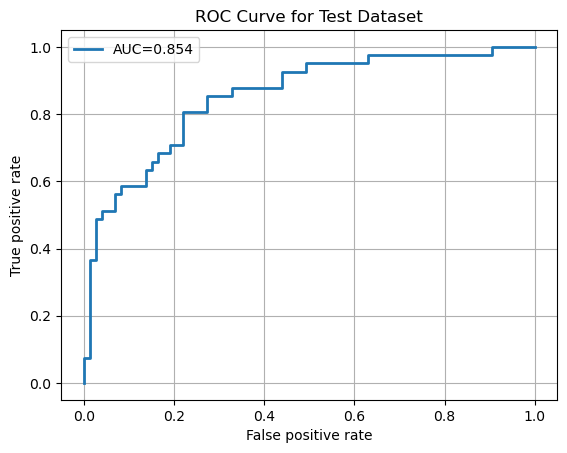

In [99]:
dropoutOneModel.plotROCgraph()

### Dropout Probability 0.5

In [100]:
dropoutNet2 = DropoutNet(in_features_count = in_features_count, dropout_prob = 0.5)
criterion = nn.BCELoss()  
optimizer = optim.SGD(dropoutNet2.parameters(), lr=lr)

In [101]:
dropoutTwoModel = ModelTrial(dropoutNet2, criterion, optimizer)

In [102]:
dropoutTwoModel.printModel()

DropoutNet(
  (fc1): Linear(in_features=23, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=16, bias=True)
  (fc5): Linear(in_features=16, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [103]:
dropoutTwoModel.printModelSummary(batch_size = batch_size)

Layer (type:depth-idx)                   Output Shape              Param #
DropoutNet                               [32, 1]                   --
├─Linear: 1-1                            [32, 256]                 6,144
├─Linear: 1-2                            [32, 128]                 32,896
├─Dropout: 1-3                           [32, 128]                 --
├─Linear: 1-4                            [32, 64]                  8,256
├─Linear: 1-5                            [32, 16]                  1,040
├─Linear: 1-6                            [32, 1]                   17
Total params: 48,353
Trainable params: 48,353
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 1.55
Input size (MB): 0.00
Forward/backward pass size (MB): 0.12
Params size (MB): 0.19
Estimated Total Size (MB): 0.32


In [104]:
dropoutTwoModel.trainingLoop(trainLoader, validationLoader, testLoader, num_epochs, decision_threshold)

Epoch 1, Training Loss: 0.71615, Training Accuracy: 33.71%
Epoch 1, Validation Loss: 0.77210, Validation Accuracy: 40.00%
Epoch 2, Training Loss: 0.70925, Training Accuracy: 54.43%
Epoch 2, Validation Loss: 0.76756, Validation Accuracy: 62.61%
Epoch 3, Training Loss: 0.70387, Training Accuracy: 66.48%
Epoch 3, Validation Loss: 0.76393, Validation Accuracy: 60.00%
Epoch 4, Training Loss: 0.69704, Training Accuracy: 66.29%
Epoch 4, Validation Loss: 0.76058, Validation Accuracy: 60.00%
Epoch 5, Training Loss: 0.69383, Training Accuracy: 66.29%
Epoch 5, Validation Loss: 0.75788, Validation Accuracy: 60.00%
Epoch 6, Training Loss: 0.68938, Training Accuracy: 66.29%
Epoch 6, Validation Loss: 0.75551, Validation Accuracy: 60.00%
Epoch 7, Training Loss: 0.68564, Training Accuracy: 66.29%
Epoch 7, Validation Loss: 0.75351, Validation Accuracy: 60.00%
Epoch 8, Training Loss: 0.68152, Training Accuracy: 66.29%
Epoch 8, Validation Loss: 0.75171, Validation Accuracy: 60.00%
Epoch 9, Training Loss: 

Epoch 72, Training Loss: 0.59534, Training Accuracy: 66.29%
Epoch 72, Validation Loss: 0.68750, Validation Accuracy: 60.00%
Epoch 73, Training Loss: 0.59271, Training Accuracy: 66.48%
Epoch 73, Validation Loss: 0.68404, Validation Accuracy: 60.00%
Epoch 74, Training Loss: 0.59098, Training Accuracy: 66.10%
Epoch 74, Validation Loss: 0.68078, Validation Accuracy: 60.00%
Epoch 75, Training Loss: 0.58764, Training Accuracy: 66.48%
Epoch 75, Validation Loss: 0.67715, Validation Accuracy: 60.00%
Epoch 76, Training Loss: 0.57787, Training Accuracy: 66.67%
Epoch 76, Validation Loss: 0.67359, Validation Accuracy: 60.00%
Epoch 77, Training Loss: 0.57724, Training Accuracy: 67.61%
Epoch 77, Validation Loss: 0.67003, Validation Accuracy: 61.74%
Epoch 78, Training Loss: 0.57019, Training Accuracy: 68.93%
Epoch 78, Validation Loss: 0.66691, Validation Accuracy: 61.74%
Epoch 79, Training Loss: 0.57592, Training Accuracy: 67.23%
Epoch 79, Validation Loss: 0.66333, Validation Accuracy: 64.35%
Epoch 80

Epoch 141, Training Loss: 0.46554, Training Accuracy: 78.34%
Epoch 141, Validation Loss: 0.63914, Validation Accuracy: 71.30%
Epoch 142, Training Loss: 0.45627, Training Accuracy: 77.21%
Epoch 142, Validation Loss: 0.63719, Validation Accuracy: 70.43%
Epoch 143, Training Loss: 0.47294, Training Accuracy: 78.34%
Epoch 143, Validation Loss: 0.63819, Validation Accuracy: 70.43%
Epoch 144, Training Loss: 0.45864, Training Accuracy: 78.34%
Epoch 144, Validation Loss: 0.63809, Validation Accuracy: 70.43%
Epoch 145, Training Loss: 0.46238, Training Accuracy: 76.65%
Epoch 145, Validation Loss: 0.63878, Validation Accuracy: 70.43%
Epoch 146, Training Loss: 0.46659, Training Accuracy: 78.34%
Epoch 146, Validation Loss: 0.64039, Validation Accuracy: 71.30%
Epoch 147, Training Loss: 0.45355, Training Accuracy: 77.97%
Epoch 147, Validation Loss: 0.64180, Validation Accuracy: 71.30%
Epoch 148, Training Loss: 0.46118, Training Accuracy: 78.34%
Epoch 148, Validation Loss: 0.64042, Validation Accuracy:

In [105]:
dropoutTwoModel.printTrainTimeStatistics()

Time taken to train model (train phase alone considered) is : 
Days: 0, Hours: 0, Minutes: 0, Seconds: 6, Microseconds: 849760


In [106]:
dropoutTwoModel.testDatasetPass(X_test, y_test, decision_threshold)

Test Dataset Passed !! Accuracy : 78.0701754385965


In [107]:
dropoutTwoModel.printMetrics()

Accuracy for Test Dataset at end of training : 78.07018
For Class 0 Precision : 0.8077 Recall : 0.8630 F1 Score : 0.8344
For Class 1 Precision : 0.7222 Recall : 0.6341 F1 Score : 0.6753


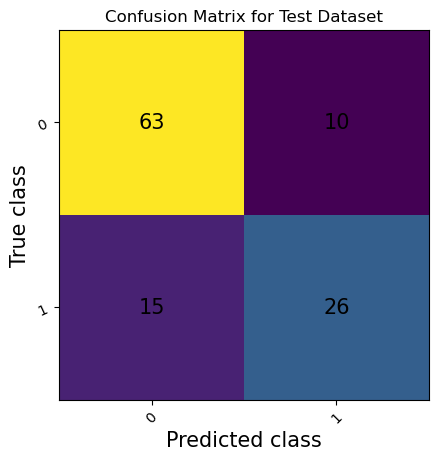

In [108]:
dropoutTwoModel.plotConfusionMatrix(decision_threshold)

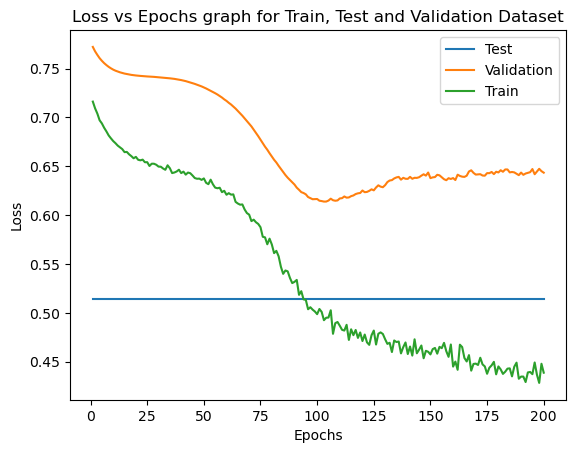

In [109]:
dropoutTwoModel.plotLossVsEpochs()

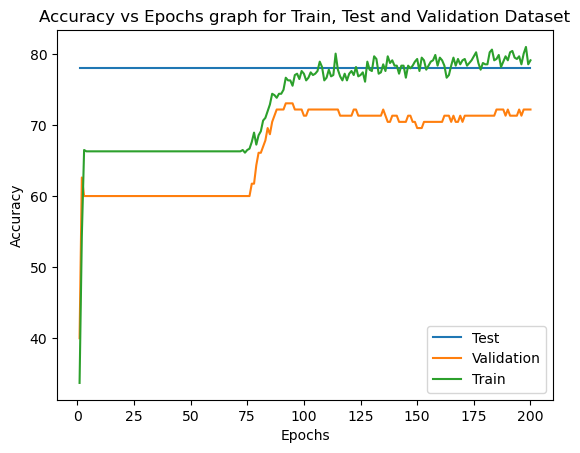

In [110]:
dropoutTwoModel.plotAccuracyVsEpochs()

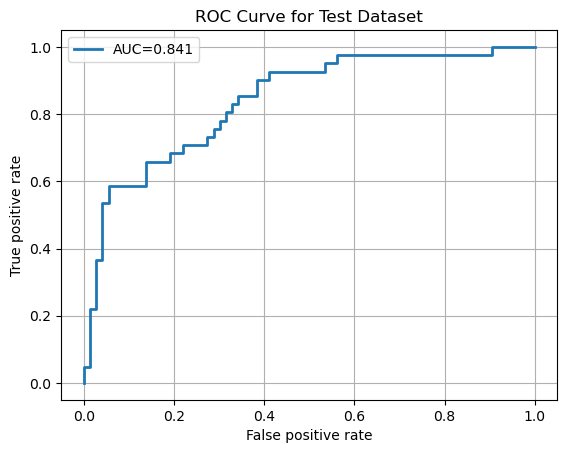

In [111]:
dropoutTwoModel.plotROCgraph()

### Dropout Probability 0.75

In [274]:
dropoutNet3 = DropoutNet(in_features_count = in_features_count, dropout_prob = 0.75)
criterion = nn.BCELoss()  
optimizer = optim.SGD(dropoutNet3.parameters(), lr=lr)

In [275]:
dropoutThreeModel = ModelTrial(dropoutNet3, criterion, optimizer)

In [276]:
dropoutThreeModel.printModel()

DropoutNet(
  (fc1): Linear(in_features=23, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=16, bias=True)
  (fc5): Linear(in_features=16, out_features=1, bias=True)
  (dropout): Dropout(p=0.75, inplace=False)
)


In [277]:
dropoutThreeModel.printModelSummary(batch_size = batch_size)

Layer (type:depth-idx)                   Output Shape              Param #
DropoutNet                               [32, 1]                   --
├─Linear: 1-1                            [32, 256]                 6,144
├─Linear: 1-2                            [32, 128]                 32,896
├─Dropout: 1-3                           [32, 128]                 --
├─Linear: 1-4                            [32, 64]                  8,256
├─Linear: 1-5                            [32, 16]                  1,040
├─Linear: 1-6                            [32, 1]                   17
Total params: 48,353
Trainable params: 48,353
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 1.55
Input size (MB): 0.00
Forward/backward pass size (MB): 0.12
Params size (MB): 0.19
Estimated Total Size (MB): 0.32


In [278]:
dropoutThreeModel.trainingLoop(trainLoader, validationLoader, testLoader, num_epochs, decision_threshold)

Epoch 1, Training Loss: 0.71455, Training Accuracy: 35.59%
Epoch 1, Validation Loss: 0.77243, Validation Accuracy: 40.00%
Epoch 2, Training Loss: 0.70896, Training Accuracy: 55.18%
Epoch 2, Validation Loss: 0.76849, Validation Accuracy: 60.00%
Epoch 3, Training Loss: 0.70351, Training Accuracy: 65.73%
Epoch 3, Validation Loss: 0.76506, Validation Accuracy: 60.00%
Epoch 4, Training Loss: 0.69858, Training Accuracy: 66.29%
Epoch 4, Validation Loss: 0.76204, Validation Accuracy: 60.00%
Epoch 5, Training Loss: 0.69445, Training Accuracy: 66.29%
Epoch 5, Validation Loss: 0.75947, Validation Accuracy: 60.00%
Epoch 6, Training Loss: 0.68997, Training Accuracy: 66.29%
Epoch 6, Validation Loss: 0.75721, Validation Accuracy: 60.00%
Epoch 7, Training Loss: 0.68700, Training Accuracy: 66.29%
Epoch 7, Validation Loss: 0.75529, Validation Accuracy: 60.00%
Epoch 8, Training Loss: 0.68338, Training Accuracy: 66.29%
Epoch 8, Validation Loss: 0.75362, Validation Accuracy: 60.00%
Epoch 9, Training Loss: 

Epoch 69, Training Loss: 0.63956, Training Accuracy: 66.29%
Epoch 69, Validation Loss: 0.73816, Validation Accuracy: 60.00%
Epoch 70, Training Loss: 0.63465, Training Accuracy: 66.29%
Epoch 70, Validation Loss: 0.73763, Validation Accuracy: 60.00%
Epoch 71, Training Loss: 0.63352, Training Accuracy: 66.29%
Epoch 71, Validation Loss: 0.73674, Validation Accuracy: 60.00%
Epoch 72, Training Loss: 0.63582, Training Accuracy: 66.29%
Epoch 72, Validation Loss: 0.73590, Validation Accuracy: 60.00%
Epoch 73, Training Loss: 0.63049, Training Accuracy: 66.29%
Epoch 73, Validation Loss: 0.73501, Validation Accuracy: 60.00%
Epoch 74, Training Loss: 0.63137, Training Accuracy: 66.29%
Epoch 74, Validation Loss: 0.73403, Validation Accuracy: 60.00%
Epoch 75, Training Loss: 0.63688, Training Accuracy: 66.29%
Epoch 75, Validation Loss: 0.73295, Validation Accuracy: 60.00%
Epoch 76, Training Loss: 0.62775, Training Accuracy: 66.29%
Epoch 76, Validation Loss: 0.73196, Validation Accuracy: 60.00%
Epoch 77

Epoch 137, Training Loss: 0.51549, Training Accuracy: 74.95%
Epoch 137, Validation Loss: 0.63704, Validation Accuracy: 71.30%
Epoch 138, Training Loss: 0.53096, Training Accuracy: 74.01%
Epoch 138, Validation Loss: 0.63587, Validation Accuracy: 71.30%
Epoch 139, Training Loss: 0.52386, Training Accuracy: 74.01%
Epoch 139, Validation Loss: 0.63537, Validation Accuracy: 71.30%
Epoch 140, Training Loss: 0.51701, Training Accuracy: 75.52%
Epoch 140, Validation Loss: 0.63523, Validation Accuracy: 71.30%
Epoch 141, Training Loss: 0.50931, Training Accuracy: 77.40%
Epoch 141, Validation Loss: 0.63489, Validation Accuracy: 71.30%
Epoch 142, Training Loss: 0.51920, Training Accuracy: 75.33%
Epoch 142, Validation Loss: 0.63462, Validation Accuracy: 71.30%
Epoch 143, Training Loss: 0.52309, Training Accuracy: 74.01%
Epoch 143, Validation Loss: 0.63243, Validation Accuracy: 72.17%
Epoch 144, Training Loss: 0.51839, Training Accuracy: 74.95%
Epoch 144, Validation Loss: 0.63259, Validation Accuracy:

In [279]:
dropoutThreeModel.printTrainTimeStatistics()

Time taken to train model (train phase alone considered) is : 
Days: 0, Hours: 0, Minutes: 0, Seconds: 10, Microseconds: 838317


In [280]:
dropoutThreeModel.testDatasetPass(X_test, y_test, decision_threshold)

Test Dataset Passed !! Accuracy : 76.3157894736842


In [281]:
dropoutThreeModel.printMetrics()

Accuracy for Test Dataset at end of training : 76.31579
For Class 0 Precision : 0.8108 Recall : 0.8219 F1 Score : 0.8163
For Class 1 Precision : 0.6750 Recall : 0.6585 F1 Score : 0.6667


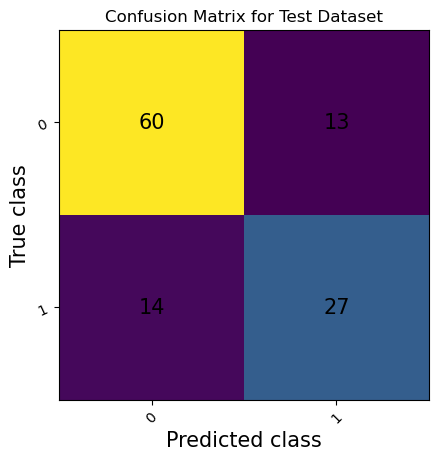

In [282]:
dropoutThreeModel.plotConfusionMatrix(decision_threshold)

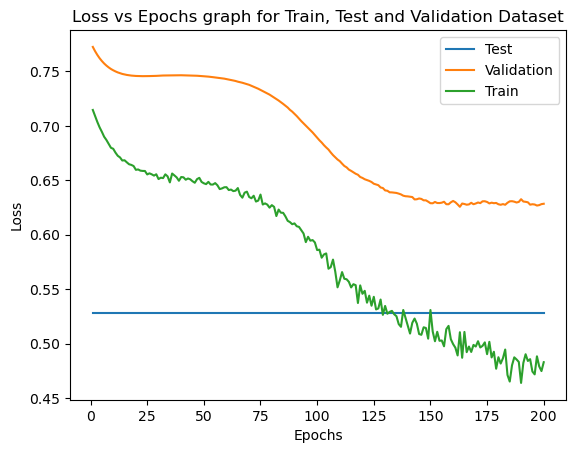

In [283]:
dropoutThreeModel.plotLossVsEpochs()

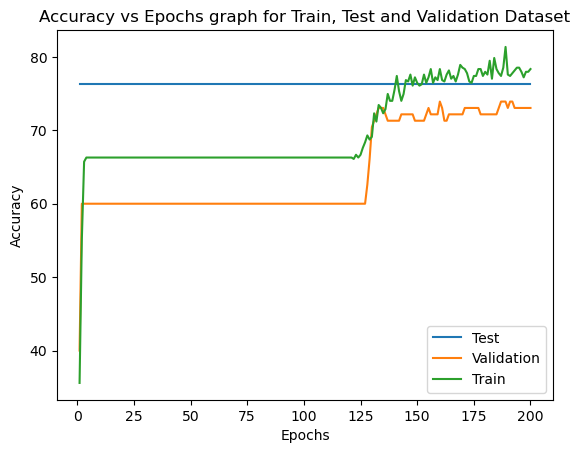

In [284]:
dropoutThreeModel.plotAccuracyVsEpochs()

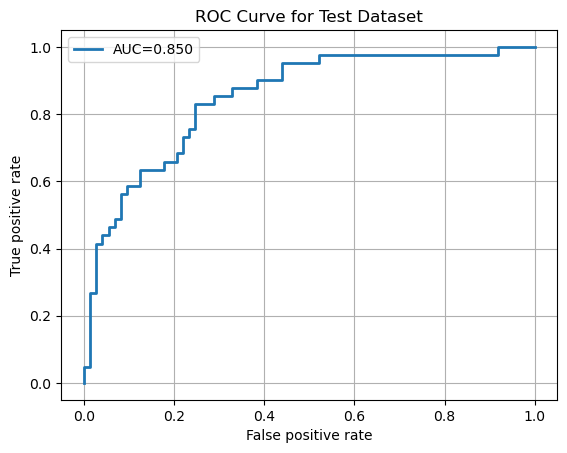

In [285]:
dropoutThreeModel.plotROCgraph()

## Hyperparameter 3 - Activation Function

In this hyperparameter search we will try different activation functions for all the hidden layers in the neural network
We will test the following three activation functions:
1) Leaky ReLU
2) Scaled Exponential Linear Unit
3) Hyperbolic tanh

### Leaky ReLU activation function

In [124]:
class ActivationNetOne(nn.Module):
    def __init__(self, in_features_count):
        super(ActivationNetOne, self).__init__()
        self.fc1 = nn.Linear(in_features_count, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64,16)
        self.fc5 = nn.Linear(16,1)
        self.in_features_count = in_features_count
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), negative_slope=0.01)
        x = F.leaky_relu(self.fc2(x), negative_slope=0.01)
        x = F.leaky_relu(self.fc3(x), negative_slope=0.01)
        x = F.leaky_relu(self.fc4(x), negative_slope=0.01)
        x = F.sigmoid(self.fc5(x))
        return x

In [125]:
activationOneNet = ActivationNetOne(in_features_count = in_features_count)
criterion = nn.BCELoss()  
optimizer = optim.SGD(activationOneNet.parameters(), lr=lr)

In [126]:
activationOneModel = ModelTrial(activationOneNet, criterion, optimizer)

In [127]:
activationOneModel.printModel()

ActivationNetOne(
  (fc1): Linear(in_features=23, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=16, bias=True)
  (fc5): Linear(in_features=16, out_features=1, bias=True)
)


In [128]:
activationOneModel.printModelSummary(batch_size = batch_size)

Layer (type:depth-idx)                   Output Shape              Param #
ActivationNetOne                         [32, 1]                   --
├─Linear: 1-1                            [32, 256]                 6,144
├─Linear: 1-2                            [32, 128]                 32,896
├─Linear: 1-3                            [32, 64]                  8,256
├─Linear: 1-4                            [32, 16]                  1,040
├─Linear: 1-5                            [32, 1]                   17
Total params: 48,353
Trainable params: 48,353
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 1.55
Input size (MB): 0.00
Forward/backward pass size (MB): 0.12
Params size (MB): 0.19
Estimated Total Size (MB): 0.32


In [129]:
activationOneModel.trainingLoop(trainLoader, validationLoader, testLoader, num_epochs, decision_threshold)

Epoch 1, Training Loss: 0.68889, Training Accuracy: 66.29%
Epoch 1, Validation Loss: 0.75617, Validation Accuracy: 60.00%
Epoch 2, Training Loss: 0.68484, Training Accuracy: 66.29%
Epoch 2, Validation Loss: 0.75443, Validation Accuracy: 60.00%
Epoch 3, Training Loss: 0.68255, Training Accuracy: 66.29%
Epoch 3, Validation Loss: 0.75298, Validation Accuracy: 60.00%
Epoch 4, Training Loss: 0.67851, Training Accuracy: 66.29%
Epoch 4, Validation Loss: 0.75168, Validation Accuracy: 60.00%
Epoch 5, Training Loss: 0.67752, Training Accuracy: 66.29%
Epoch 5, Validation Loss: 0.75066, Validation Accuracy: 60.00%
Epoch 6, Training Loss: 0.67476, Training Accuracy: 66.29%
Epoch 6, Validation Loss: 0.74978, Validation Accuracy: 60.00%
Epoch 7, Training Loss: 0.67359, Training Accuracy: 66.29%
Epoch 7, Validation Loss: 0.74906, Validation Accuracy: 60.00%
Epoch 8, Training Loss: 0.67032, Training Accuracy: 66.29%
Epoch 8, Validation Loss: 0.74843, Validation Accuracy: 60.00%
Epoch 9, Training Loss: 

Epoch 72, Training Loss: 0.64757, Training Accuracy: 66.29%
Epoch 72, Validation Loss: 0.74807, Validation Accuracy: 60.00%
Epoch 73, Training Loss: 0.65073, Training Accuracy: 66.29%
Epoch 73, Validation Loss: 0.74781, Validation Accuracy: 60.00%
Epoch 74, Training Loss: 0.64639, Training Accuracy: 66.29%
Epoch 74, Validation Loss: 0.74766, Validation Accuracy: 60.00%
Epoch 75, Training Loss: 0.64865, Training Accuracy: 66.29%
Epoch 75, Validation Loss: 0.74742, Validation Accuracy: 60.00%
Epoch 76, Training Loss: 0.64922, Training Accuracy: 66.29%
Epoch 76, Validation Loss: 0.74715, Validation Accuracy: 60.00%
Epoch 77, Training Loss: 0.64738, Training Accuracy: 66.29%
Epoch 77, Validation Loss: 0.74693, Validation Accuracy: 60.00%
Epoch 78, Training Loss: 0.64714, Training Accuracy: 66.29%
Epoch 78, Validation Loss: 0.74667, Validation Accuracy: 60.00%
Epoch 79, Training Loss: 0.65017, Training Accuracy: 66.29%
Epoch 79, Validation Loss: 0.74633, Validation Accuracy: 60.00%
Epoch 80

Epoch 139, Training Loss: 0.56453, Training Accuracy: 72.69%
Epoch 139, Validation Loss: 0.66119, Validation Accuracy: 69.57%
Epoch 140, Training Loss: 0.56431, Training Accuracy: 74.01%
Epoch 140, Validation Loss: 0.65825, Validation Accuracy: 69.57%
Epoch 141, Training Loss: 0.55824, Training Accuracy: 73.82%
Epoch 141, Validation Loss: 0.65520, Validation Accuracy: 70.43%
Epoch 142, Training Loss: 0.55699, Training Accuracy: 73.82%
Epoch 142, Validation Loss: 0.65212, Validation Accuracy: 72.17%
Epoch 143, Training Loss: 0.54999, Training Accuracy: 75.14%
Epoch 143, Validation Loss: 0.64917, Validation Accuracy: 71.30%
Epoch 144, Training Loss: 0.54905, Training Accuracy: 74.39%
Epoch 144, Validation Loss: 0.64594, Validation Accuracy: 71.30%
Epoch 145, Training Loss: 0.54350, Training Accuracy: 75.33%
Epoch 145, Validation Loss: 0.64324, Validation Accuracy: 71.30%
Epoch 146, Training Loss: 0.54223, Training Accuracy: 76.08%
Epoch 146, Validation Loss: 0.64034, Validation Accuracy:

In [130]:
activationOneModel.printTrainTimeStatistics()

Time taken to train model (train phase alone considered) is : 
Days: 0, Hours: 0, Minutes: 0, Seconds: 7, Microseconds: 797539


In [131]:
activationOneModel.testDatasetPass(X_test, y_test, decision_threshold)

Test Dataset Passed !! Accuracy : 79.82456140350877


In [132]:
activationOneModel.printMetrics()

Accuracy for Test Dataset at end of training : 79.82456
For Class 0 Precision : 0.8049 Recall : 0.9041 F1 Score : 0.8516
For Class 1 Precision : 0.7812 Recall : 0.6098 F1 Score : 0.6849


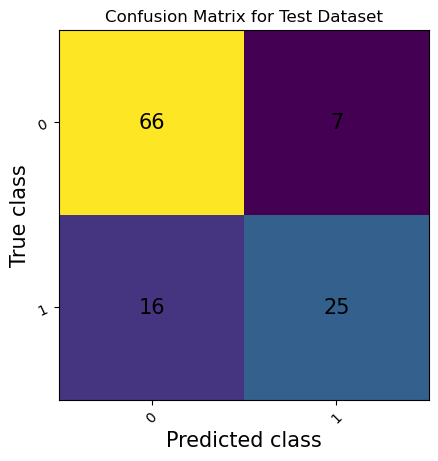

In [133]:
activationOneModel.plotConfusionMatrix(decision_threshold)

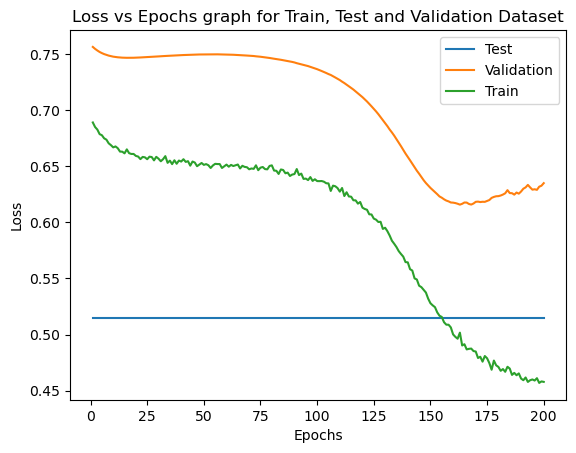

In [134]:
activationOneModel.plotLossVsEpochs()

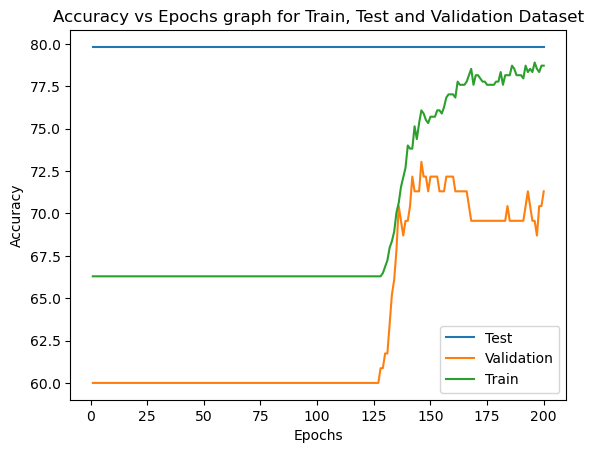

In [135]:
activationOneModel.plotAccuracyVsEpochs()

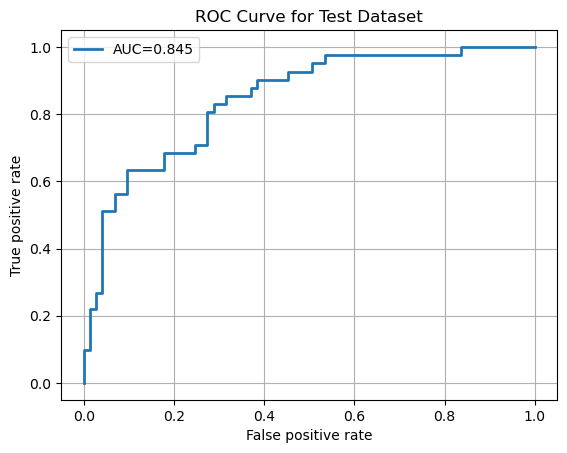

In [136]:
activationOneModel.plotROCgraph()

### SELU activation function

In [137]:
class ActivationNetTwo(nn.Module):
    def __init__(self, in_features_count):
        super(ActivationNetTwo, self).__init__()
        self.fc1 = nn.Linear(in_features_count, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64,16)
        self.fc5 = nn.Linear(16,1)
        self.in_features_count = in_features_count
    def forward(self, x):
        x = F.selu(self.fc1(x))
        x = F.selu(self.fc2(x))
        x = F.selu(self.fc3(x))
        x = F.selu(self.fc4(x))
        x = F.sigmoid(self.fc5(x))
        return x

In [138]:
activationTwoNet = ActivationNetTwo(in_features_count = in_features_count)
criterion = nn.BCELoss()  
optimizer = optim.SGD(activationTwoNet.parameters(), lr=lr)

In [139]:
activationTwoModel = ModelTrial(activationTwoNet, criterion, optimizer)

In [140]:
activationTwoModel.printModel()

ActivationNetTwo(
  (fc1): Linear(in_features=23, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=16, bias=True)
  (fc5): Linear(in_features=16, out_features=1, bias=True)
)


In [141]:
activationTwoModel.printModelSummary(batch_size = batch_size)

Layer (type:depth-idx)                   Output Shape              Param #
ActivationNetTwo                         [32, 1]                   --
├─Linear: 1-1                            [32, 256]                 6,144
├─Linear: 1-2                            [32, 128]                 32,896
├─Linear: 1-3                            [32, 64]                  8,256
├─Linear: 1-4                            [32, 16]                  1,040
├─Linear: 1-5                            [32, 1]                   17
Total params: 48,353
Trainable params: 48,353
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 1.55
Input size (MB): 0.00
Forward/backward pass size (MB): 0.12
Params size (MB): 0.19
Estimated Total Size (MB): 0.32


In [142]:
activationTwoModel.trainingLoop(trainLoader, validationLoader, testLoader, num_epochs, decision_threshold)

Epoch 1, Training Loss: 0.68690, Training Accuracy: 64.60%
Epoch 1, Validation Loss: 0.73235, Validation Accuracy: 64.35%
Epoch 2, Training Loss: 0.64857, Training Accuracy: 70.81%
Epoch 2, Validation Loss: 0.70398, Validation Accuracy: 67.83%
Epoch 3, Training Loss: 0.61609, Training Accuracy: 71.94%
Epoch 3, Validation Loss: 0.67976, Validation Accuracy: 67.83%
Epoch 4, Training Loss: 0.59206, Training Accuracy: 73.63%
Epoch 4, Validation Loss: 0.66006, Validation Accuracy: 69.57%
Epoch 5, Training Loss: 0.56608, Training Accuracy: 75.33%
Epoch 5, Validation Loss: 0.64382, Validation Accuracy: 70.43%
Epoch 6, Training Loss: 0.54746, Training Accuracy: 75.71%
Epoch 6, Validation Loss: 0.63115, Validation Accuracy: 73.04%
Epoch 7, Training Loss: 0.53231, Training Accuracy: 77.02%
Epoch 7, Validation Loss: 0.62175, Validation Accuracy: 71.30%
Epoch 8, Training Loss: 0.51527, Training Accuracy: 77.21%
Epoch 8, Validation Loss: 0.61569, Validation Accuracy: 72.17%
Epoch 9, Training Loss: 

Epoch 69, Training Loss: 0.45518, Training Accuracy: 79.28%
Epoch 69, Validation Loss: 0.61873, Validation Accuracy: 70.43%
Epoch 70, Training Loss: 0.45660, Training Accuracy: 79.28%
Epoch 70, Validation Loss: 0.61410, Validation Accuracy: 70.43%
Epoch 71, Training Loss: 0.44572, Training Accuracy: 79.47%
Epoch 71, Validation Loss: 0.61916, Validation Accuracy: 70.43%
Epoch 72, Training Loss: 0.44905, Training Accuracy: 79.28%
Epoch 72, Validation Loss: 0.62075, Validation Accuracy: 70.43%
Epoch 73, Training Loss: 0.44917, Training Accuracy: 79.47%
Epoch 73, Validation Loss: 0.62100, Validation Accuracy: 70.43%
Epoch 74, Training Loss: 0.44792, Training Accuracy: 80.04%
Epoch 74, Validation Loss: 0.62034, Validation Accuracy: 71.30%
Epoch 75, Training Loss: 0.44464, Training Accuracy: 80.04%
Epoch 75, Validation Loss: 0.62515, Validation Accuracy: 70.43%
Epoch 76, Training Loss: 0.45161, Training Accuracy: 79.66%
Epoch 76, Validation Loss: 0.62483, Validation Accuracy: 70.43%
Epoch 77

Epoch 137, Training Loss: 0.42220, Training Accuracy: 80.60%
Epoch 137, Validation Loss: 0.64541, Validation Accuracy: 69.57%
Epoch 138, Training Loss: 0.41913, Training Accuracy: 80.41%
Epoch 138, Validation Loss: 0.65020, Validation Accuracy: 69.57%
Epoch 139, Training Loss: 0.42073, Training Accuracy: 81.17%
Epoch 139, Validation Loss: 0.64641, Validation Accuracy: 69.57%
Epoch 140, Training Loss: 0.42112, Training Accuracy: 80.98%
Epoch 140, Validation Loss: 0.64165, Validation Accuracy: 69.57%
Epoch 141, Training Loss: 0.42342, Training Accuracy: 80.79%
Epoch 141, Validation Loss: 0.65247, Validation Accuracy: 68.70%
Epoch 142, Training Loss: 0.42544, Training Accuracy: 81.36%
Epoch 142, Validation Loss: 0.64530, Validation Accuracy: 68.70%
Epoch 143, Training Loss: 0.41945, Training Accuracy: 80.79%
Epoch 143, Validation Loss: 0.65044, Validation Accuracy: 67.83%
Epoch 144, Training Loss: 0.42313, Training Accuracy: 80.79%
Epoch 144, Validation Loss: 0.65098, Validation Accuracy:

In [143]:
activationTwoModel.printTrainTimeStatistics()

Time taken to train model (train phase alone considered) is : 
Days: 0, Hours: 0, Minutes: 0, Seconds: 8, Microseconds: 595608


In [144]:
activationTwoModel.testDatasetPass(X_test, y_test, decision_threshold)

Test Dataset Passed !! Accuracy : 73.6842105263158


In [145]:
activationTwoModel.printMetrics()

Accuracy for Test Dataset at end of training : 73.68421
For Class 0 Precision : 0.7792 Recall : 0.8219 F1 Score : 0.8000
For Class 1 Precision : 0.6486 Recall : 0.5854 F1 Score : 0.6154


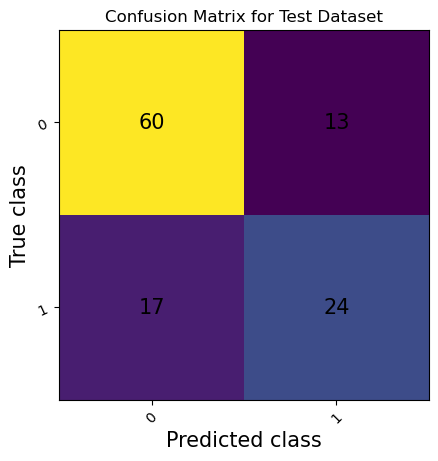

In [146]:
activationTwoModel.plotConfusionMatrix(decision_threshold)

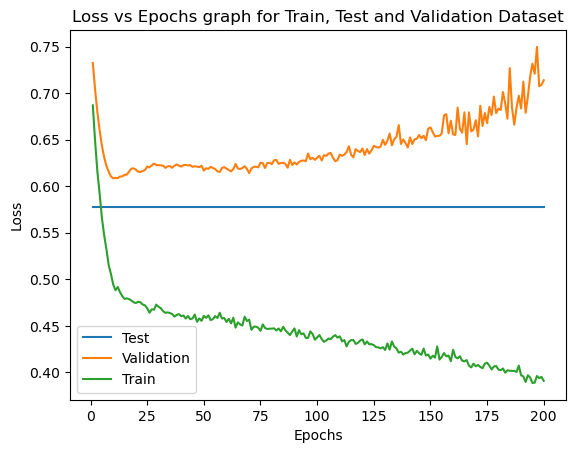

In [147]:
activationTwoModel.plotLossVsEpochs()

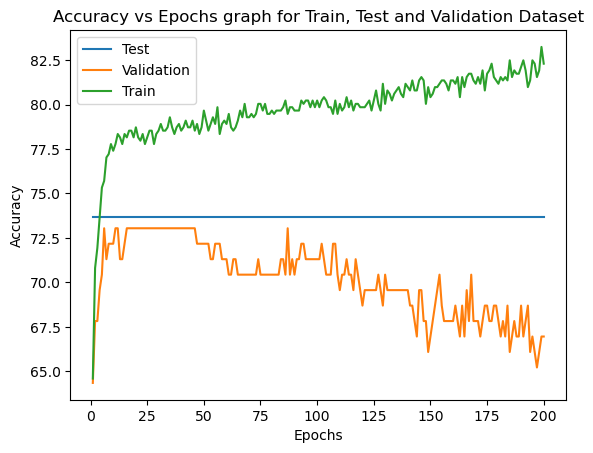

In [148]:
activationTwoModel.plotAccuracyVsEpochs()

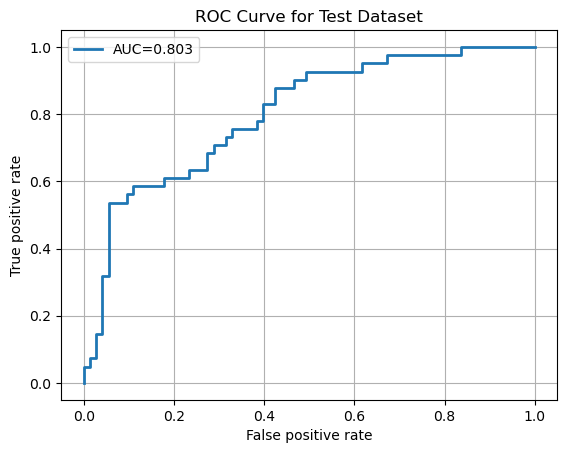

In [149]:
activationTwoModel.plotROCgraph()

### Hyperbolic Tanh activation function

In [150]:
class ActivationNetThree(nn.Module):
    def __init__(self, in_features_count):
        super(ActivationNetThree, self).__init__()
        self.fc1 = nn.Linear(in_features_count, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64,16)
        self.fc5 = nn.Linear(16,1)
        self.in_features_count = in_features_count
    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = F.tanh(self.fc3(x))
        x = F.tanh(self.fc4(x))
        x = F.sigmoid(self.fc5(x))
        return x

In [151]:
activationThreeNet = ActivationNetThree(in_features_count = in_features_count)
criterion = nn.BCELoss()  
optimizer = optim.SGD(activationThreeNet.parameters(), lr=lr)

In [152]:
activationThreeModel = ModelTrial(activationThreeNet, criterion, optimizer)

In [153]:
activationThreeModel.printModel()

ActivationNetThree(
  (fc1): Linear(in_features=23, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=16, bias=True)
  (fc5): Linear(in_features=16, out_features=1, bias=True)
)


In [154]:
activationThreeModel.printModelSummary(batch_size = batch_size)

Layer (type:depth-idx)                   Output Shape              Param #
ActivationNetThree                       [32, 1]                   --
├─Linear: 1-1                            [32, 256]                 6,144
├─Linear: 1-2                            [32, 128]                 32,896
├─Linear: 1-3                            [32, 64]                  8,256
├─Linear: 1-4                            [32, 16]                  1,040
├─Linear: 1-5                            [32, 1]                   17
Total params: 48,353
Trainable params: 48,353
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 1.55
Input size (MB): 0.00
Forward/backward pass size (MB): 0.12
Params size (MB): 0.19
Estimated Total Size (MB): 0.32


In [155]:
activationThreeModel.trainingLoop(trainLoader, validationLoader, testLoader, num_epochs, decision_threshold)

Epoch 1, Training Loss: 0.72037, Training Accuracy: 34.27%
Epoch 1, Validation Loss: 0.77397, Validation Accuracy: 44.35%
Epoch 2, Training Loss: 0.70861, Training Accuracy: 52.73%
Epoch 2, Validation Loss: 0.76515, Validation Accuracy: 58.26%
Epoch 3, Training Loss: 0.69812, Training Accuracy: 66.29%
Epoch 3, Validation Loss: 0.75713, Validation Accuracy: 61.74%
Epoch 4, Training Loss: 0.68814, Training Accuracy: 67.42%
Epoch 4, Validation Loss: 0.74980, Validation Accuracy: 60.87%
Epoch 5, Training Loss: 0.67984, Training Accuracy: 66.48%
Epoch 5, Validation Loss: 0.74317, Validation Accuracy: 60.00%
Epoch 6, Training Loss: 0.67209, Training Accuracy: 66.29%
Epoch 6, Validation Loss: 0.73692, Validation Accuracy: 60.00%
Epoch 7, Training Loss: 0.66401, Training Accuracy: 66.48%
Epoch 7, Validation Loss: 0.73095, Validation Accuracy: 60.00%
Epoch 8, Training Loss: 0.65481, Training Accuracy: 66.48%
Epoch 8, Validation Loss: 0.72494, Validation Accuracy: 60.00%
Epoch 9, Training Loss: 

Epoch 68, Training Loss: 0.46887, Training Accuracy: 78.72%
Epoch 68, Validation Loss: 0.62588, Validation Accuracy: 73.04%
Epoch 69, Training Loss: 0.46789, Training Accuracy: 78.53%
Epoch 69, Validation Loss: 0.62677, Validation Accuracy: 73.04%
Epoch 70, Training Loss: 0.46967, Training Accuracy: 78.72%
Epoch 70, Validation Loss: 0.62614, Validation Accuracy: 73.04%
Epoch 71, Training Loss: 0.47178, Training Accuracy: 78.34%
Epoch 71, Validation Loss: 0.62660, Validation Accuracy: 73.04%
Epoch 72, Training Loss: 0.46422, Training Accuracy: 78.91%
Epoch 72, Validation Loss: 0.62717, Validation Accuracy: 73.04%
Epoch 73, Training Loss: 0.47056, Training Accuracy: 78.15%
Epoch 73, Validation Loss: 0.62673, Validation Accuracy: 73.04%
Epoch 74, Training Loss: 0.46769, Training Accuracy: 78.53%
Epoch 74, Validation Loss: 0.62654, Validation Accuracy: 73.04%
Epoch 75, Training Loss: 0.46426, Training Accuracy: 78.15%
Epoch 75, Validation Loss: 0.62682, Validation Accuracy: 73.04%
Epoch 76

Epoch 137, Training Loss: 0.46035, Training Accuracy: 78.53%
Epoch 137, Validation Loss: 0.62547, Validation Accuracy: 70.43%
Epoch 138, Training Loss: 0.45708, Training Accuracy: 79.10%
Epoch 138, Validation Loss: 0.62581, Validation Accuracy: 70.43%
Epoch 139, Training Loss: 0.45613, Training Accuracy: 78.91%
Epoch 139, Validation Loss: 0.62660, Validation Accuracy: 70.43%
Epoch 140, Training Loss: 0.46634, Training Accuracy: 78.53%
Epoch 140, Validation Loss: 0.62609, Validation Accuracy: 70.43%
Epoch 141, Training Loss: 0.46185, Training Accuracy: 78.53%
Epoch 141, Validation Loss: 0.62521, Validation Accuracy: 70.43%
Epoch 142, Training Loss: 0.46219, Training Accuracy: 78.91%
Epoch 142, Validation Loss: 0.62610, Validation Accuracy: 70.43%
Epoch 143, Training Loss: 0.45792, Training Accuracy: 78.91%
Epoch 143, Validation Loss: 0.62610, Validation Accuracy: 70.43%
Epoch 144, Training Loss: 0.46101, Training Accuracy: 79.10%
Epoch 144, Validation Loss: 0.62544, Validation Accuracy:

In [156]:
activationThreeModel.printTrainTimeStatistics()

Time taken to train model (train phase alone considered) is : 
Days: 0, Hours: 0, Minutes: 0, Seconds: 6, Microseconds: 91648


In [157]:
activationThreeModel.testDatasetPass(X_test, y_test, decision_threshold)

Test Dataset Passed !! Accuracy : 78.0701754385965


In [158]:
activationThreeModel.printMetrics()

Accuracy for Test Dataset at end of training : 78.07018
For Class 0 Precision : 0.8077 Recall : 0.8630 F1 Score : 0.8344
For Class 1 Precision : 0.7222 Recall : 0.6341 F1 Score : 0.6753


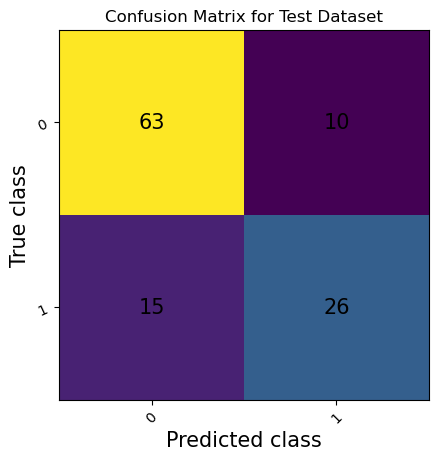

In [159]:
activationThreeModel.plotConfusionMatrix(decision_threshold)

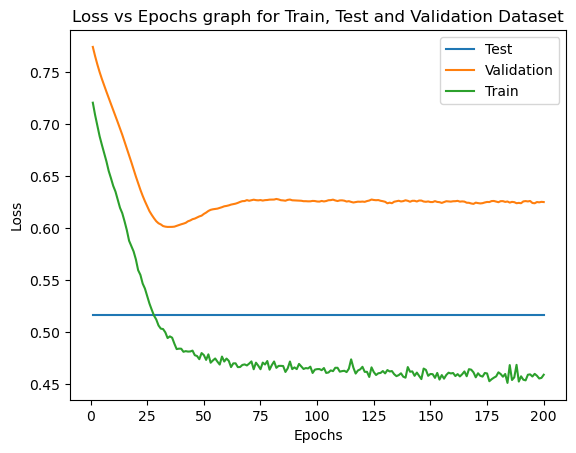

In [160]:
activationThreeModel.plotLossVsEpochs()

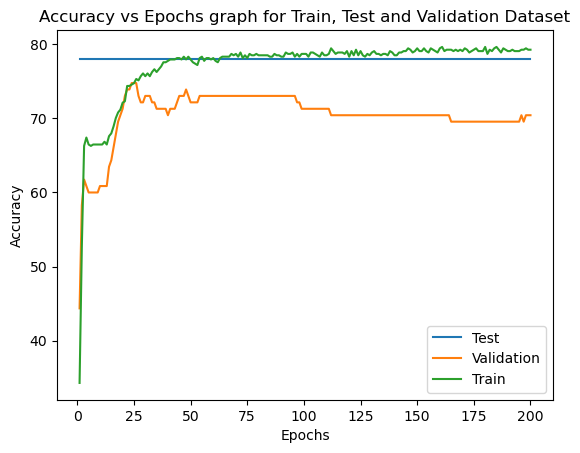

In [161]:
activationThreeModel.plotAccuracyVsEpochs()

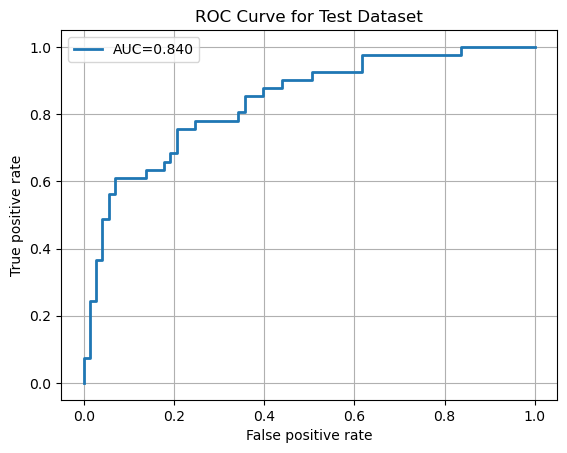

In [162]:
activationThreeModel.plotROCgraph()

# Comparison of all the 10 models created above

## Comparison of Test Accuracy

In [163]:
def modelAccuracyComparison(modelNames, accuracy_array):
    models = range(len(modelNames))
    plt.barh(models, accuracy_array, align='center')
    
    for i, v in enumerate(accuracy_array):
        plt.text(v, i, f'{v:.2f}', va='center')

    plt.yticks(models, modelNames)
    plt.xlabel('Accuracy')
    plt.title('Comparison of Models\' Test Accuracy')
    plt.show()

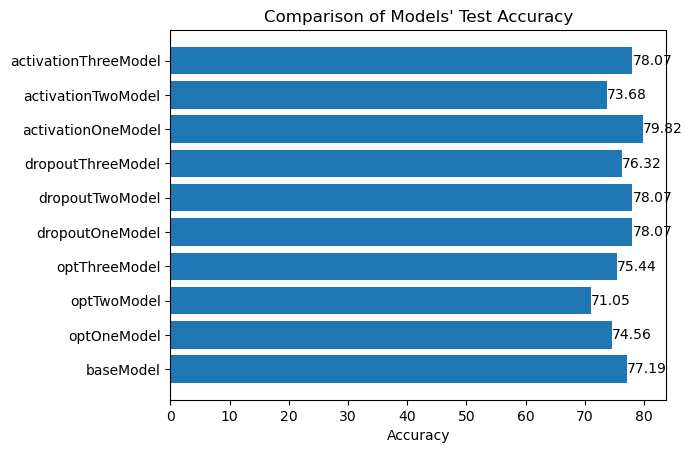

In [286]:
accuracy_array = [baseModel.test_outputs['accuracy'], optOneModel.test_outputs['accuracy'], optTwoModel.test_outputs['accuracy'], optThreeModel.test_outputs['accuracy'], dropoutOneModel.test_outputs['accuracy'], dropoutTwoModel.test_outputs['accuracy'], dropoutThreeModel.test_outputs['accuracy'], activationOneModel.test_outputs['accuracy'], activationTwoModel.test_outputs['accuracy'], activationThreeModel.test_outputs['accuracy']] 
modelNames = ['baseModel', 'optOneModel', 'optTwoModel', 'optThreeModel', 'dropoutOneModel', 'dropoutTwoModel', 'dropoutThreeModel', 'activationOneModel', 'activationTwoModel', 'activationThreeModel']

modelAccuracyComparison(modelNames, accuracy_array)

# Training Optimizations

## Learning Rate Scheduling

In [257]:
lrsNet = ActivationNetOne(in_features_count = in_features_count)
criterion = nn.BCELoss()  
lrsOptimizer = optim.SGD(lrsNet.parameters(), lr=lr)
lrsScheduler = optim.lr_scheduler.ReduceLROnPlateau(lrsOptimizer, factor = 0.2, threshold_mode = 'abs')

In [258]:
class LRSModelTrial(ModelTrial):
    def __init__(self, model, criterion, optimizer, scheduler):
        super(LRSModelTrial, self).__init__(model, criterion, optimizer)
        self.scheduler = scheduler
    
    def trainingLoop(self, trainLoader, validationLoader, testLoader, num_epochs, decision_threshold, verbose = True):
        self.epochs = range(1, num_epochs+1)
        cumulative_train_time = datetime.timedelta()
        train_dataset_size = len(trainLoader.dataset)
        test_dataset_size = len(testLoader.dataset)
        validation_dataset_size = len(validationLoader.dataset)
    
        for epoch in self.epochs:
            training_loss = 0.0
            training_correct = 0
            t1 = datetime.datetime.now()
            self.model.train()
            for inputs, labels in trainLoader:
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                y_pred = (outputs >= decision_threshold).float()
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                training_loss += loss.item() / (train_dataset_size / trainLoader.batch_size)
                training_correct += (y_pred == labels).sum().item()

            t2 = datetime.datetime.now()
            cumulative_train_time += t2-t1

            training_accuracy = 100 * training_correct / train_dataset_size
            if verbose:
                print(f"Epoch {epoch}, Training Loss: {training_loss:.5f}, Training Accuracy: {training_accuracy:.2f}%")
            self.train_metrics['accuracy'].append(training_accuracy)
            self.train_metrics['loss'].append(training_loss)
            # Validation loop
            validation_loss = 0.0
            validation_correct = 0
            self.model.eval()
            with torch.no_grad():  # Disable gradient computation
                for inputs, labels in validationLoader:
                    outputs = self.model(inputs)
                    y_pred = (outputs >= decision_threshold).float()
                    loss = self.criterion(outputs, labels)
                    validation_loss += loss.item() / (validation_dataset_size / validationLoader.batch_size)

                    validation_correct += (y_pred == labels).sum().item()
                validation_accuracy = 100 * validation_correct / validation_dataset_size
                if verbose:
                    print(f"Epoch {epoch}, Validation Loss: {validation_loss:.5f}, Validation Accuracy: {validation_accuracy:.2f}%")
                self.validation_metrics['accuracy'].append(validation_accuracy)
                self.validation_metrics['loss'].append(validation_loss)
            self.scheduler.step(validation_loss)
        
        self.model.eval()
        for epoch in self.epochs:
            test_loss = 0.0
            test_correct = 0
            with torch.no_grad():     
                for inputs, labels in testLoader:
                    outputs = self.model(inputs)
                    y_pred = (outputs >= decision_threshold).float()
                    loss = self.criterion(outputs, labels)
                    test_loss += loss.item() / (test_dataset_size / testLoader.batch_size)

                    test_correct += (y_pred == labels).sum().item()

                test_accuracy = 100 * test_correct / test_dataset_size
                self.test_metrics['accuracy'].append(test_accuracy)
                self.test_metrics['loss'].append(test_loss)
        print(f"Epoch {epoch} Training Completed!!")
        print(f"Epoch {epoch}, Testing Loss: {test_loss:.5f}, Testing Accuracy: {test_accuracy:.2f}%")  
        self.train_time = cumulative_train_time


In [259]:
lrsModel = LRSModelTrial(lrsNet, criterion, lrsOptimizer, lrsScheduler)

In [260]:
lrsModel.printModel()

ActivationNetOne(
  (fc1): Linear(in_features=23, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=16, bias=True)
  (fc5): Linear(in_features=16, out_features=1, bias=True)
)


In [261]:
lrsModel.printModelSummary(batch_size = batch_size)

Layer (type:depth-idx)                   Output Shape              Param #
ActivationNetOne                         [32, 1]                   --
├─Linear: 1-1                            [32, 256]                 6,144
├─Linear: 1-2                            [32, 128]                 32,896
├─Linear: 1-3                            [32, 64]                  8,256
├─Linear: 1-4                            [32, 16]                  1,040
├─Linear: 1-5                            [32, 1]                   17
Total params: 48,353
Trainable params: 48,353
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 1.55
Input size (MB): 0.00
Forward/backward pass size (MB): 0.12
Params size (MB): 0.19
Estimated Total Size (MB): 0.32


In [262]:
lrsModel.trainingLoop(trainLoader, validationLoader, testLoader, num_epochs, decision_threshold)

Epoch 1, Training Loss: 0.75223, Training Accuracy: 33.71%
Epoch 1, Validation Loss: 0.79845, Validation Accuracy: 40.00%
Epoch 2, Training Loss: 0.74207, Training Accuracy: 33.71%
Epoch 2, Validation Loss: 0.79120, Validation Accuracy: 40.00%
Epoch 3, Training Loss: 0.73388, Training Accuracy: 33.71%
Epoch 3, Validation Loss: 0.78463, Validation Accuracy: 40.00%
Epoch 4, Training Loss: 0.72483, Training Accuracy: 33.71%
Epoch 4, Validation Loss: 0.77911, Validation Accuracy: 40.00%
Epoch 5, Training Loss: 0.71799, Training Accuracy: 33.71%
Epoch 5, Validation Loss: 0.77414, Validation Accuracy: 40.00%
Epoch 6, Training Loss: 0.71127, Training Accuracy: 44.26%
Epoch 6, Validation Loss: 0.76980, Validation Accuracy: 57.39%
Epoch 7, Training Loss: 0.70523, Training Accuracy: 66.48%
Epoch 7, Validation Loss: 0.76600, Validation Accuracy: 60.00%
Epoch 8, Training Loss: 0.69985, Training Accuracy: 66.29%
Epoch 8, Validation Loss: 0.76267, Validation Accuracy: 60.00%
Epoch 9, Training Loss: 

Epoch 68, Training Loss: 0.62370, Training Accuracy: 66.29%
Epoch 68, Validation Loss: 0.72479, Validation Accuracy: 60.00%
Epoch 69, Training Loss: 0.62451, Training Accuracy: 66.29%
Epoch 69, Validation Loss: 0.72312, Validation Accuracy: 60.00%
Epoch 70, Training Loss: 0.62157, Training Accuracy: 66.29%
Epoch 70, Validation Loss: 0.72132, Validation Accuracy: 60.00%
Epoch 71, Training Loss: 0.61473, Training Accuracy: 66.29%
Epoch 71, Validation Loss: 0.71959, Validation Accuracy: 60.00%
Epoch 72, Training Loss: 0.61704, Training Accuracy: 66.29%
Epoch 72, Validation Loss: 0.71758, Validation Accuracy: 60.00%
Epoch 73, Training Loss: 0.61597, Training Accuracy: 66.29%
Epoch 73, Validation Loss: 0.71534, Validation Accuracy: 60.00%
Epoch 74, Training Loss: 0.61125, Training Accuracy: 66.29%
Epoch 74, Validation Loss: 0.71309, Validation Accuracy: 60.00%
Epoch 75, Training Loss: 0.60739, Training Accuracy: 66.29%
Epoch 75, Validation Loss: 0.71105, Validation Accuracy: 60.00%
Epoch 76

Epoch 136, Training Loss: 0.46899, Training Accuracy: 77.78%
Epoch 136, Validation Loss: 0.62436, Validation Accuracy: 70.43%
Epoch 137, Training Loss: 0.47274, Training Accuracy: 77.97%
Epoch 137, Validation Loss: 0.62404, Validation Accuracy: 70.43%
Epoch 138, Training Loss: 0.47291, Training Accuracy: 77.97%
Epoch 138, Validation Loss: 0.62415, Validation Accuracy: 70.43%
Epoch 139, Training Loss: 0.47049, Training Accuracy: 77.78%
Epoch 139, Validation Loss: 0.62508, Validation Accuracy: 70.43%
Epoch 140, Training Loss: 0.46965, Training Accuracy: 78.15%
Epoch 140, Validation Loss: 0.62452, Validation Accuracy: 70.43%
Epoch 141, Training Loss: 0.47035, Training Accuracy: 77.97%
Epoch 141, Validation Loss: 0.62422, Validation Accuracy: 70.43%
Epoch 142, Training Loss: 0.46886, Training Accuracy: 77.97%
Epoch 142, Validation Loss: 0.62413, Validation Accuracy: 70.43%
Epoch 143, Training Loss: 0.46143, Training Accuracy: 77.97%
Epoch 143, Validation Loss: 0.62404, Validation Accuracy:

In [263]:
lrsModel.printTrainTimeStatistics()

Time taken to train model (train phase alone considered) is : 
Days: 0, Hours: 0, Minutes: 0, Seconds: 10, Microseconds: 654675


In [264]:
lrsModel.testDatasetPass(X_test, y_test, decision_threshold)

Test Dataset Passed !! Accuracy : 80.70175438596492


In [265]:
lrsModel.printMetrics()

Accuracy for Test Dataset at end of training : 80.70175
For Class 0 Precision : 0.8148 Recall : 0.9041 F1 Score : 0.8571
For Class 1 Precision : 0.7879 Recall : 0.6341 F1 Score : 0.7027


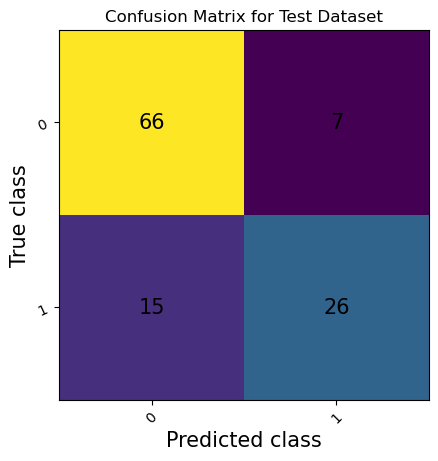

In [266]:
lrsModel.plotConfusionMatrix(decision_threshold)

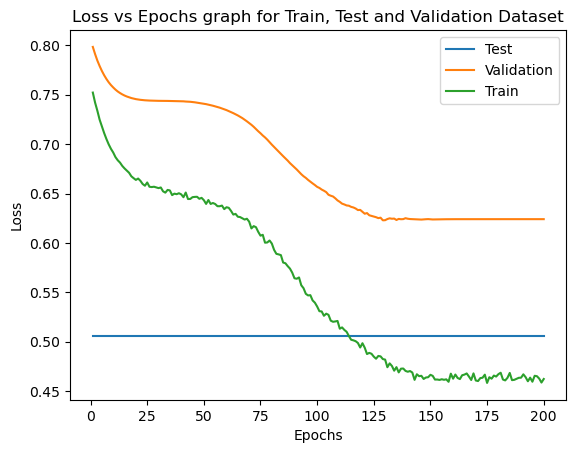

In [267]:
lrsModel.plotLossVsEpochs()

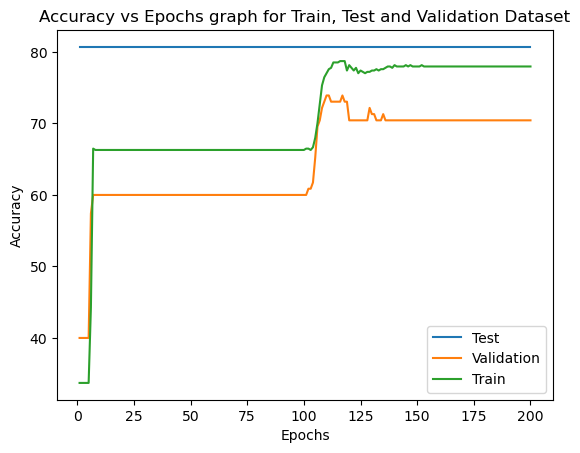

In [268]:
lrsModel.plotAccuracyVsEpochs()

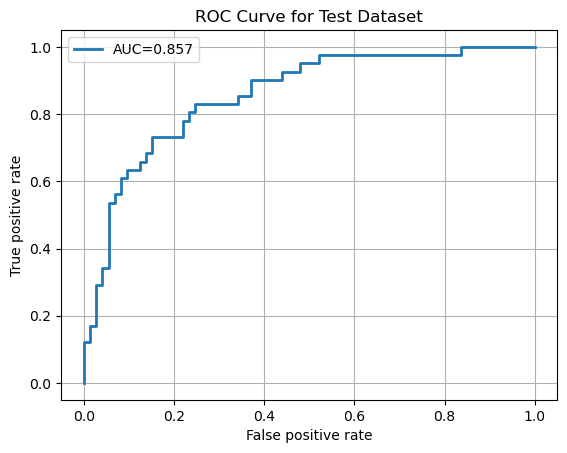

In [269]:
lrsModel.plotROCgraph()

## Batch Norm

In [224]:
class BatchNormNet(nn.Module):
    def __init__(self, in_features_count):
        super(BatchNormNet, self).__init__()
        self.fc1 = nn.Linear(in_features_count, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64,16)
        self.fc5 = nn.Linear(16,1)
        self.batchnorm = nn.BatchNorm1d(64)
        self.in_features_count = in_features_count
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), negative_slope=0.01)
        x = F.leaky_relu(self.fc2(x), negative_slope=0.01)
        x = F.leaky_relu(self.fc3(x), negative_slope=0.01)
        x = self.batchnorm(x)
        x = F.leaky_relu(self.fc4(x), negative_slope=0.01)
        x = F.sigmoid(self.fc5(x))
        return x

In [225]:
batchNormNet = BatchNormNet(in_features_count = in_features_count)
criterion = nn.BCELoss()  
batchNormOptimizer = optim.SGD(batchNormNet.parameters(), lr=lr)

In [226]:
batchNormModel = ModelTrial(batchNormNet, criterion, batchNormOptimizer)

In [227]:
batchNormModel.printModel()

BatchNormNet(
  (fc1): Linear(in_features=23, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=16, bias=True)
  (fc5): Linear(in_features=16, out_features=1, bias=True)
  (batchnorm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [228]:
batchNormModel.printModelSummary(batch_size = batch_size)

Layer (type:depth-idx)                   Output Shape              Param #
BatchNormNet                             [32, 1]                   --
├─Linear: 1-1                            [32, 256]                 6,144
├─Linear: 1-2                            [32, 128]                 32,896
├─Linear: 1-3                            [32, 64]                  8,256
├─BatchNorm1d: 1-4                       [32, 64]                  128
├─Linear: 1-5                            [32, 16]                  1,040
├─Linear: 1-6                            [32, 1]                   17
Total params: 48,481
Trainable params: 48,481
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 1.55
Input size (MB): 0.00
Forward/backward pass size (MB): 0.14
Params size (MB): 0.19
Estimated Total Size (MB): 0.33


In [229]:
batchNormModel.trainingLoop(trainLoader, validationLoader, testLoader, num_epochs, decision_threshold)

Epoch 1, Training Loss: 0.66390, Training Accuracy: 66.48%
Epoch 1, Validation Loss: 0.74606, Validation Accuracy: 60.00%
Epoch 2, Training Loss: 0.62201, Training Accuracy: 67.61%
Epoch 2, Validation Loss: 0.73329, Validation Accuracy: 60.00%
Epoch 3, Training Loss: 0.59384, Training Accuracy: 70.81%
Epoch 3, Validation Loss: 0.70544, Validation Accuracy: 60.00%
Epoch 4, Training Loss: 0.56831, Training Accuracy: 74.58%
Epoch 4, Validation Loss: 0.66925, Validation Accuracy: 70.43%
Epoch 5, Training Loss: 0.55217, Training Accuracy: 75.33%
Epoch 5, Validation Loss: 0.64175, Validation Accuracy: 70.43%
Epoch 6, Training Loss: 0.53845, Training Accuracy: 76.08%
Epoch 6, Validation Loss: 0.62563, Validation Accuracy: 71.30%
Epoch 7, Training Loss: 0.51858, Training Accuracy: 78.34%
Epoch 7, Validation Loss: 0.61619, Validation Accuracy: 72.17%
Epoch 8, Training Loss: 0.50582, Training Accuracy: 77.40%
Epoch 8, Validation Loss: 0.61247, Validation Accuracy: 71.30%
Epoch 9, Training Loss: 

Epoch 72, Training Loss: 0.11694, Training Accuracy: 98.12%
Epoch 72, Validation Loss: 1.00033, Validation Accuracy: 69.57%
Epoch 73, Training Loss: 0.12024, Training Accuracy: 96.61%
Epoch 73, Validation Loss: 1.27880, Validation Accuracy: 63.48%
Epoch 74, Training Loss: 0.14614, Training Accuracy: 93.97%
Epoch 74, Validation Loss: 1.13421, Validation Accuracy: 63.48%
Epoch 75, Training Loss: 0.15711, Training Accuracy: 95.10%
Epoch 75, Validation Loss: 1.00268, Validation Accuracy: 69.57%
Epoch 76, Training Loss: 0.11670, Training Accuracy: 96.99%
Epoch 76, Validation Loss: 1.08022, Validation Accuracy: 69.57%
Epoch 77, Training Loss: 0.08448, Training Accuracy: 98.68%
Epoch 77, Validation Loss: 1.09452, Validation Accuracy: 66.09%
Epoch 78, Training Loss: 0.13580, Training Accuracy: 95.48%
Epoch 78, Validation Loss: 1.35817, Validation Accuracy: 68.70%
Epoch 79, Training Loss: 0.12600, Training Accuracy: 96.05%
Epoch 79, Validation Loss: 1.10863, Validation Accuracy: 67.83%
Epoch 80

Epoch 142, Training Loss: 0.07885, Training Accuracy: 97.18%
Epoch 142, Validation Loss: 1.59915, Validation Accuracy: 65.22%
Epoch 143, Training Loss: 0.04708, Training Accuracy: 98.31%
Epoch 143, Validation Loss: 1.69689, Validation Accuracy: 63.48%
Epoch 144, Training Loss: 0.06932, Training Accuracy: 97.55%
Epoch 144, Validation Loss: 1.77387, Validation Accuracy: 60.00%
Epoch 145, Training Loss: 0.03786, Training Accuracy: 98.87%
Epoch 145, Validation Loss: 1.53788, Validation Accuracy: 65.22%
Epoch 146, Training Loss: 0.02866, Training Accuracy: 99.62%
Epoch 146, Validation Loss: 1.69895, Validation Accuracy: 64.35%
Epoch 147, Training Loss: 0.02184, Training Accuracy: 99.62%
Epoch 147, Validation Loss: 1.71663, Validation Accuracy: 64.35%
Epoch 148, Training Loss: 0.02732, Training Accuracy: 99.62%
Epoch 148, Validation Loss: 1.43869, Validation Accuracy: 64.35%
Epoch 149, Training Loss: 0.03917, Training Accuracy: 99.06%
Epoch 149, Validation Loss: 1.57628, Validation Accuracy:

In [230]:
batchNormModel.printTrainTimeStatistics()

Time taken to train model (train phase alone considered) is : 
Days: 0, Hours: 0, Minutes: 0, Seconds: 7, Microseconds: 590755


In [231]:
batchNormModel.testDatasetPass(X_test, y_test, decision_threshold)

Test Dataset Passed !! Accuracy : 72.80701754385964


In [232]:
batchNormModel.printMetrics()

Accuracy for Test Dataset at end of training : 72.80702
For Class 0 Precision : 0.7838 Recall : 0.7945 F1 Score : 0.7891
For Class 1 Precision : 0.6250 Recall : 0.6098 F1 Score : 0.6173


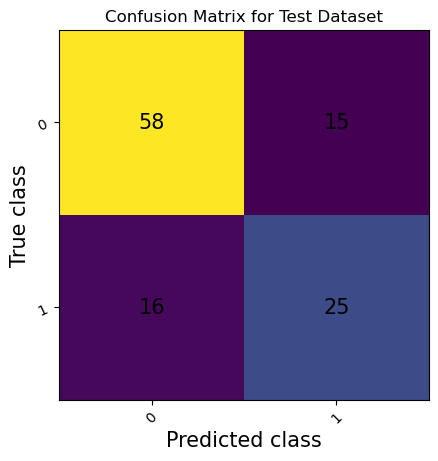

In [233]:
batchNormModel.plotConfusionMatrix(decision_threshold)

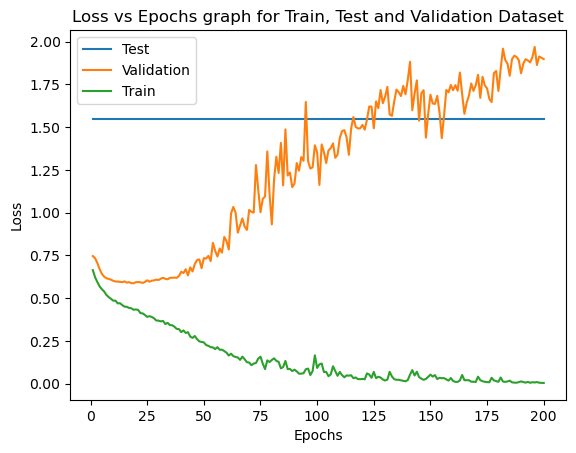

In [234]:
batchNormModel.plotLossVsEpochs()

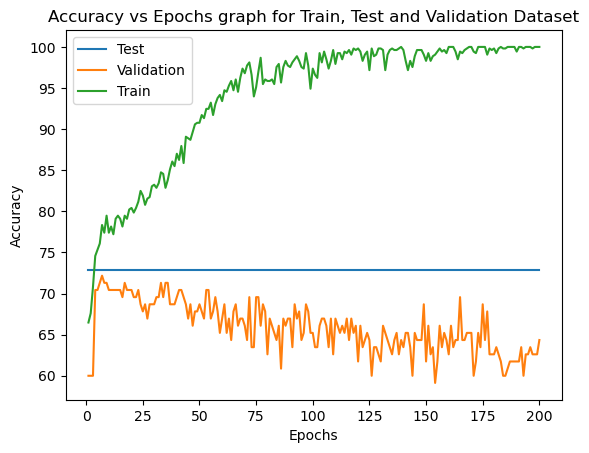

In [235]:
batchNormModel.plotAccuracyVsEpochs()

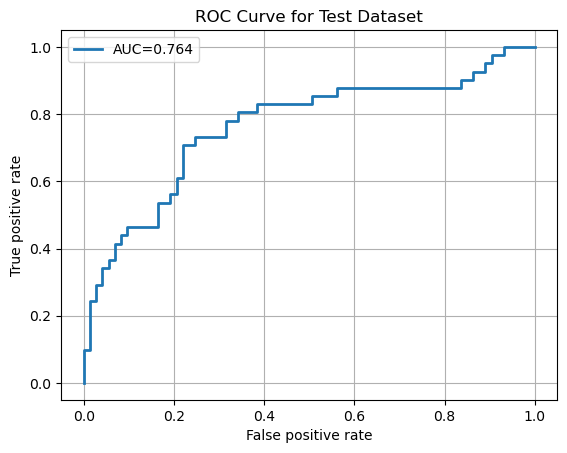

In [236]:
batchNormModel.plotROCgraph()

## Early Stopping

In [237]:
earlyStopNet = ActivationNetOne(in_features_count = in_features_count)
criterion = nn.BCELoss()  
earlyStopOptimizer = optim.SGD(earlyStopNet.parameters(), lr=lr)

In [238]:
class EarlyStopModelTrial(ModelTrial):
    def __init__(self, model, criterion, optimizer):
        super(EarlyStopModelTrial, self).__init__(model, criterion, optimizer)

    def trainingLoop(self, trainLoader, validationLoader, testLoader, num_epochs, decision_threshold, patience = num_epochs/10, verbose = True):
        self.epochs = range(1, num_epochs+1)
        cumulative_train_time = datetime.timedelta()
        train_dataset_size = len(trainLoader.dataset)
        test_dataset_size = len(testLoader.dataset)
        validation_dataset_size = len(validationLoader.dataset)
        
        min_validation_loss = float('inf')
        patience_ctr = 0
        break_epoch = self.epochs[-1]
    
        for epoch in self.epochs:
            training_loss = 0.0
            training_correct = 0
            t1 = datetime.datetime.now()
            self.model.train()
            for inputs, labels in trainLoader:
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                y_pred = (outputs >= decision_threshold).float()
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                training_loss += loss.item() / (train_dataset_size / trainLoader.batch_size)
                training_correct += (y_pred == labels).sum().item()

            t2 = datetime.datetime.now()
            cumulative_train_time += t2-t1

            training_accuracy = 100 * training_correct / train_dataset_size
            if verbose:
                print(f"Epoch {epoch}, Training Loss: {training_loss:.5f}, Training Accuracy: {training_accuracy:.2f}%")
            self.train_metrics['accuracy'].append(training_accuracy)
            self.train_metrics['loss'].append(training_loss)
            # Validation loop
            validation_loss = 0.0
            validation_correct = 0
            self.model.eval()
            with torch.no_grad():  # Disable gradient computation
                for inputs, labels in validationLoader:
                    outputs = self.model(inputs)
                    y_pred = (outputs >= decision_threshold).float()
                    loss = self.criterion(outputs, labels)
                    validation_loss += loss.item() / (validation_dataset_size / validationLoader.batch_size)

                    validation_correct += (y_pred == labels).sum().item()
                validation_accuracy = 100 * validation_correct / validation_dataset_size
                if verbose:
                    print(f"Epoch {epoch}, Validation Loss: {validation_loss:.5f}, Validation Accuracy: {validation_accuracy:.2f}%")
                self.validation_metrics['accuracy'].append(validation_accuracy)
                self.validation_metrics['loss'].append(validation_loss)
            
            if validation_loss <= min_validation_loss:
                min_validation_loss = validation_loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print("\nEarly stopping")
                    break_epoch = epoch
                    break
        
        self.epochs = self.epochs[:break_epoch]
        self.model.eval()
        for epoch in self.epochs:
            test_loss = 0.0
            test_correct = 0
            with torch.no_grad():     
                for inputs, labels in testLoader:
                    outputs = self.model(inputs)
                    y_pred = (outputs >= decision_threshold).float()
                    loss = self.criterion(outputs, labels)
                    test_loss += loss.item() / (test_dataset_size / testLoader.batch_size)

                    test_correct += (y_pred == labels).sum().item()

                test_accuracy = 100 * test_correct / test_dataset_size
                self.test_metrics['accuracy'].append(test_accuracy)
                self.test_metrics['loss'].append(test_loss)
        print(f"Epoch {epoch} Training Completed!!")
        print(f"Epoch {epoch}, Testing Loss: {test_loss:.5f}, Testing Accuracy: {test_accuracy:.2f}%")  
        self.train_time = cumulative_train_time


In [239]:
earlyStopModel = EarlyStopModelTrial(earlyStopNet, criterion, earlyStopOptimizer)

In [240]:
earlyStopModel.printModel()

ActivationNetOne(
  (fc1): Linear(in_features=23, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=16, bias=True)
  (fc5): Linear(in_features=16, out_features=1, bias=True)
)


In [241]:
earlyStopModel.printModelSummary(batch_size = batch_size)

Layer (type:depth-idx)                   Output Shape              Param #
ActivationNetOne                         [32, 1]                   --
├─Linear: 1-1                            [32, 256]                 6,144
├─Linear: 1-2                            [32, 128]                 32,896
├─Linear: 1-3                            [32, 64]                  8,256
├─Linear: 1-4                            [32, 16]                  1,040
├─Linear: 1-5                            [32, 1]                   17
Total params: 48,353
Trainable params: 48,353
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 1.55
Input size (MB): 0.00
Forward/backward pass size (MB): 0.12
Params size (MB): 0.19
Estimated Total Size (MB): 0.32


In [242]:
earlyStopModel.trainingLoop(trainLoader, validationLoader, testLoader, num_epochs, decision_threshold, patience = 20)

Epoch 1, Training Loss: 0.70223, Training Accuracy: 66.29%
Epoch 1, Validation Loss: 0.76456, Validation Accuracy: 60.00%
Epoch 2, Training Loss: 0.69738, Training Accuracy: 66.29%
Epoch 2, Validation Loss: 0.76160, Validation Accuracy: 60.00%
Epoch 3, Training Loss: 0.69333, Training Accuracy: 66.29%
Epoch 3, Validation Loss: 0.75908, Validation Accuracy: 60.00%
Epoch 4, Training Loss: 0.68927, Training Accuracy: 66.29%
Epoch 4, Validation Loss: 0.75686, Validation Accuracy: 60.00%
Epoch 5, Training Loss: 0.68574, Training Accuracy: 66.29%
Epoch 5, Validation Loss: 0.75494, Validation Accuracy: 60.00%
Epoch 6, Training Loss: 0.68296, Training Accuracy: 66.29%
Epoch 6, Validation Loss: 0.75329, Validation Accuracy: 60.00%
Epoch 7, Training Loss: 0.68047, Training Accuracy: 66.29%
Epoch 7, Validation Loss: 0.75188, Validation Accuracy: 60.00%
Epoch 8, Training Loss: 0.67735, Training Accuracy: 66.29%
Epoch 8, Validation Loss: 0.75063, Validation Accuracy: 60.00%
Epoch 9, Training Loss: 

Epoch 69, Training Loss: 0.61697, Training Accuracy: 66.29%
Epoch 69, Validation Loss: 0.71361, Validation Accuracy: 60.00%
Epoch 70, Training Loss: 0.61416, Training Accuracy: 66.29%
Epoch 70, Validation Loss: 0.71160, Validation Accuracy: 60.00%
Epoch 71, Training Loss: 0.61615, Training Accuracy: 66.29%
Epoch 71, Validation Loss: 0.70935, Validation Accuracy: 60.00%
Epoch 72, Training Loss: 0.61074, Training Accuracy: 66.29%
Epoch 72, Validation Loss: 0.70727, Validation Accuracy: 60.00%
Epoch 73, Training Loss: 0.60713, Training Accuracy: 66.29%
Epoch 73, Validation Loss: 0.70521, Validation Accuracy: 60.00%
Epoch 74, Training Loss: 0.60633, Training Accuracy: 66.29%
Epoch 74, Validation Loss: 0.70297, Validation Accuracy: 60.00%
Epoch 75, Training Loss: 0.60393, Training Accuracy: 66.29%
Epoch 75, Validation Loss: 0.70062, Validation Accuracy: 60.00%
Epoch 76, Training Loss: 0.60257, Training Accuracy: 66.29%
Epoch 76, Validation Loss: 0.69826, Validation Accuracy: 60.00%
Epoch 77

Epoch 134 Training Completed!!
Epoch 134, Testing Loss: 0.51003, Testing Accuracy: 78.07%


In [243]:
earlyStopModel.printTrainTimeStatistics()

Time taken to train model (train phase alone considered) is : 
Days: 0, Hours: 0, Minutes: 0, Seconds: 4, Microseconds: 806151


In [244]:
earlyStopModel.testDatasetPass(X_test, y_test, decision_threshold)

Test Dataset Passed !! Accuracy : 78.0701754385965


In [245]:
earlyStopModel.printMetrics()

Accuracy for Test Dataset at end of training : 78.07018
For Class 0 Precision : 0.8077 Recall : 0.8630 F1 Score : 0.8344
For Class 1 Precision : 0.7222 Recall : 0.6341 F1 Score : 0.6753


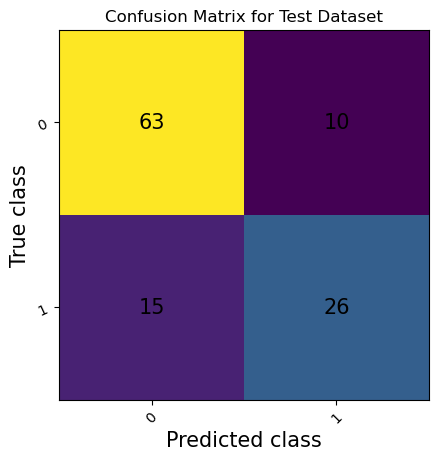

In [246]:
earlyStopModel.plotConfusionMatrix(decision_threshold)

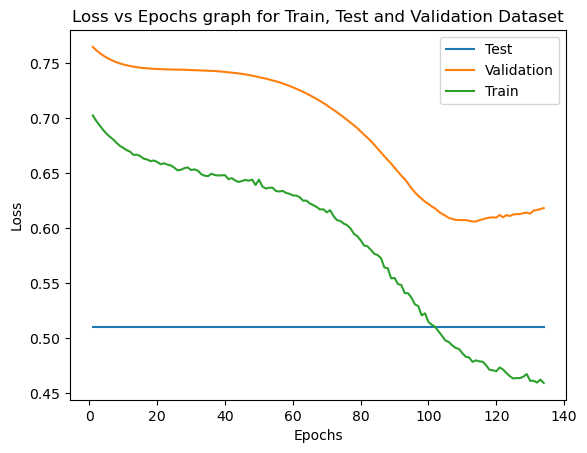

In [247]:
earlyStopModel.plotLossVsEpochs()

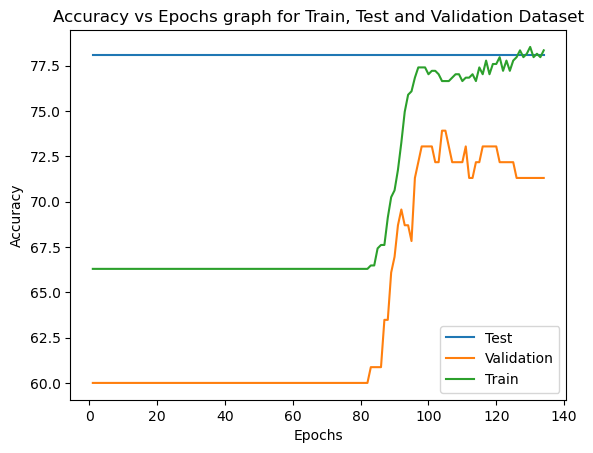

In [248]:
earlyStopModel.plotAccuracyVsEpochs()

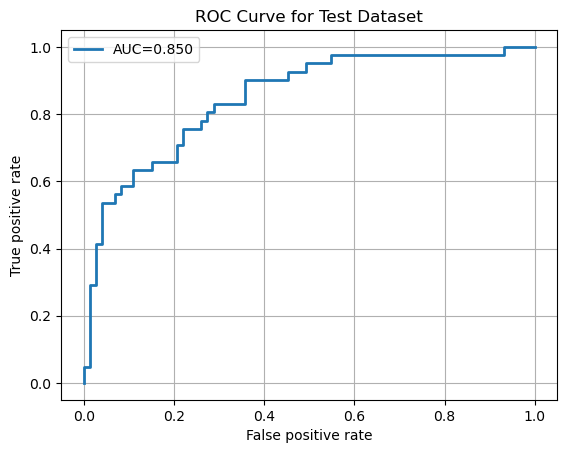

In [249]:
earlyStopModel.plotROCgraph()

## K-Fold

In [250]:
k_folds = 5
KFold = StratifiedKFold(n_splits=k_folds, shuffle=True)
KFoldModels = {}
y_kfold_indexes = y.index.to_numpy()

for fold, (train_index, validation_index) in enumerate(KFold.split(X, y),1):
    print("\n Fold {}".format(fold))
    X_train_kFold, X_validation_kFold = X.loc[y_kfold_indexes[train_index]], X.loc[y_kfold_indexes[validation_index]]
    y_train_kFold, y_validation_kFold = y.loc[y_kfold_indexes[train_index]], y.loc[y_kfold_indexes[validation_index]]
    
    kFoldTrainDataset = TensorDataset(torch.from_numpy(X_train_kFold.to_numpy()).float(), torch.from_numpy(y_train_kFold.to_numpy().reshape(-1,1)).float())
    kFoldTrainLoader = DataLoader(kFoldTrainDataset, batch_size = batch_size, shuffle = True)

    kFoldValidationDataset = TensorDataset(torch.from_numpy(X_validation_kFold.to_numpy()).float(), torch.from_numpy(y_validation_kFold.to_numpy().reshape(-1,1)).float())
    kFoldValidationLoader = DataLoader(kFoldValidationDataset, batch_size = batch_size)
    
    kFoldNet = ActivationNetOne(in_features_count = in_features_count)
    criterion = nn.BCELoss()  
    kFoldOptimizer = optim.SGD(kFoldNet.parameters(), lr=lr)
    
    kFoldModel = ModelTrial(kFoldNet, criterion, kFoldOptimizer)
    
    kFoldModel.trainingLoop(trainLoader = kFoldTrainLoader, validationLoader = kFoldValidationLoader, testLoader = kFoldValidationLoader, num_epochs = num_epochs, decision_threshold = decision_threshold, verbose = False)

    kFoldModel.printTrainTimeStatistics()

    kFoldModel.testDatasetPass(X_validation_kFold, y_validation_kFold, decision_threshold)

    kFoldModel.printMetrics()
    
    KFoldModels[str(fold)] = {'model':kFoldModel, 'train_index':train_index, 'validation_index':validation_index}
      


 Fold 1
Epoch 200 Training Completed!!
Epoch 200, Testing Loss: 0.58503, Testing Accuracy: 72.37%
Time taken to train model (train phase alone considered) is : 
Days: 0, Hours: 0, Minutes: 0, Seconds: 7, Microseconds: 266632
Test Dataset Passed !! Accuracy : 72.36842105263158
Accuracy for Test Dataset at end of training : 72.36842
For Class 0 Precision : 0.7642 Recall : 0.8265 F1 Score : 0.7941
For Class 1 Precision : 0.6304 Recall : 0.5370 F1 Score : 0.5800

 Fold 2
Epoch 200 Training Completed!!
Epoch 200, Testing Loss: 0.55664, Testing Accuracy: 72.37%
Time taken to train model (train phase alone considered) is : 
Days: 0, Hours: 0, Minutes: 0, Seconds: 7, Microseconds: 255667
Test Dataset Passed !! Accuracy : 72.36842105263158
Accuracy for Test Dataset at end of training : 72.36842
For Class 0 Precision : 0.7714 Recall : 0.8182 F1 Score : 0.7941
For Class 1 Precision : 0.6170 Recall : 0.5472 F1 Score : 0.5800

 Fold 3
Epoch 200 Training Completed!!
Epoch 200, Testing Loss: 0.53319

In [251]:
max_KFold_validation_accuracy = 0.0
max_KFold_validation_accuracy_fold = ''
avg_KFold_validation_accuracy = 0.0
for k,v in KFoldModels.items():
    if max_KFold_validation_accuracy < v['model'].test_outputs['accuracy']:
        max_KFold_validation_accuracy_fold = k
        max_KFold_validation_accuracy = v['model'].test_outputs['accuracy']
    avg_KFold_validation_accuracy += (v['model'].test_outputs['accuracy'] / k_folds)
    print('For Fold {}, validation/test accuracy {}'.format(k, v['model'].test_outputs['accuracy']))

print("Average Validation/Test Accuracy: {}".format(avg_KFold_validation_accuracy))
print("Max Validation/Test Accuracy: {}".format(max_KFold_validation_accuracy))

For Fold 1, validation/test accuracy 72.36842105263158
For Fold 2, validation/test accuracy 72.36842105263158
For Fold 3, validation/test accuracy 70.39473684210526
For Fold 4, validation/test accuracy 80.92105263157895
For Fold 5, validation/test accuracy 76.97368421052632
Average Validation/Test Accuracy: 74.60526315789474
Max Validation/Test Accuracy: 80.92105263157895


In [252]:
KFoldModels[max_KFold_validation_accuracy_fold]['model'].printMetrics()

Accuracy for Test Dataset at end of training : 80.92105
For Class 0 Precision : 0.8182 Recall : 0.9091 F1 Score : 0.8612
For Class 1 Precision : 0.7857 Recall : 0.6226 F1 Score : 0.6947


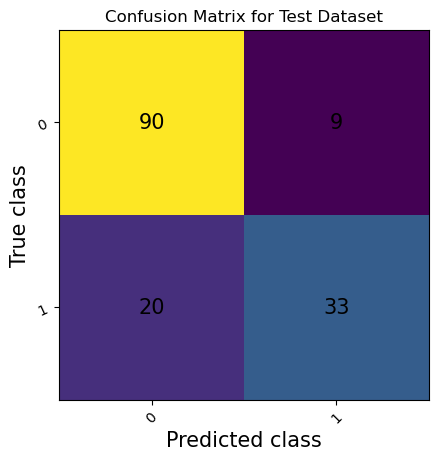

In [253]:
KFoldModels[max_KFold_validation_accuracy_fold]['model'].plotConfusionMatrix(decision_threshold)

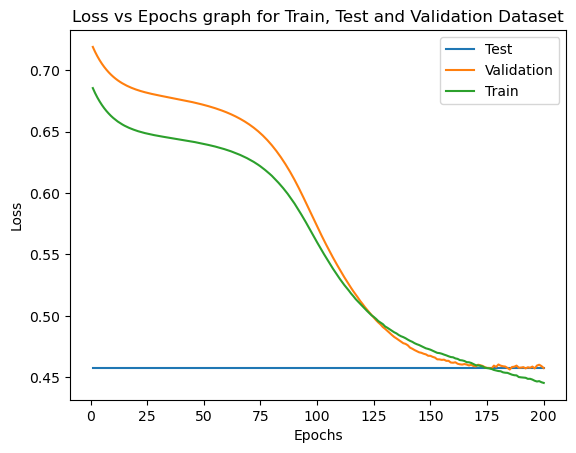

In [254]:
KFoldModels[max_KFold_validation_accuracy_fold]['model'].plotLossVsEpochs()

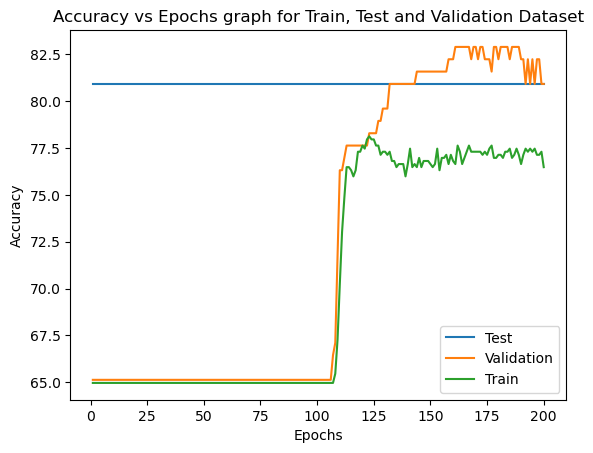

In [255]:
KFoldModels[max_KFold_validation_accuracy_fold]['model'].plotAccuracyVsEpochs()

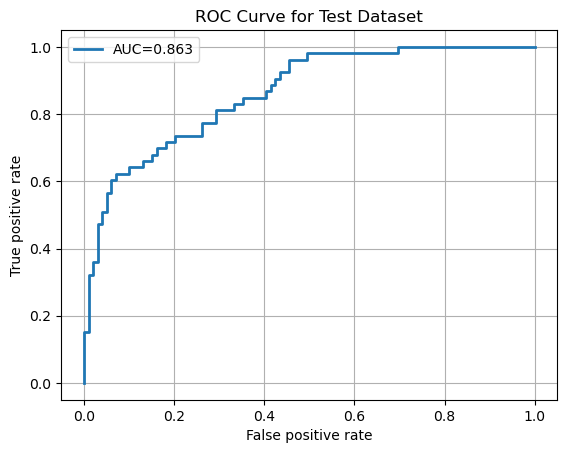

In [256]:
KFoldModels[max_KFold_validation_accuracy_fold]['model'].plotROCgraph()

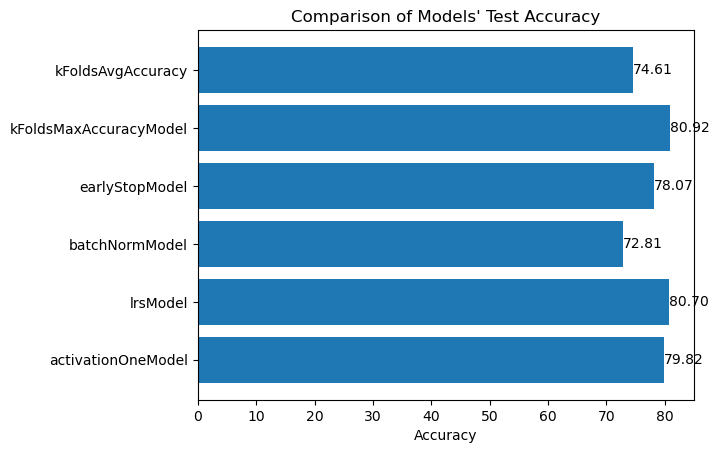

In [270]:
accuracy_array = [activationOneModel.test_outputs['accuracy'], lrsModel.test_outputs['accuracy'], batchNormModel.test_outputs['accuracy'], earlyStopModel.test_outputs['accuracy'], KFoldModels[max_KFold_validation_accuracy_fold]['model'].test_outputs['accuracy'], avg_KFold_validation_accuracy] 
modelNames = ['activationOneModel', 'lrsModel', 'batchNormModel', 'earlyStopModel', 'kFoldsMaxAccuracyModel', 'kFoldsAvgAccuracy']

modelAccuracyComparison(modelNames, accuracy_array)

In [273]:
models_dict = {
    'bestDropoutModel': dropoutOneModel.model.state_dict(),
    'bestOptModel': optThreeModel.model.state_dict(),
    'bestActivationModel': activationOneModel.model.state_dict(),
    'bestOptimizedModel': KFoldModels[max_KFold_validation_accuracy_fold]['model'].model.state_dict(),
}

#### References
1) https://docs.python.org/3/index.html
2) https://matplotlib.org/stable/
3) https://seaborn.pydata.org/api.html
4) https://pandas.pydata.org/docs/reference/index.html
5) https://numpy.org/doc/stable/index.html
6) https://pytorch.org/docs/stable/index.html
7) https://github.com/TylerYep/torchinfo#readme
8) https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html
9) https://torchmetrics.readthedocs.io/en/stable/